In [ ]:
!pip install transformers
!pip install wget
from scipy.spatial.distance import cosine
from sklearn.manifold import TSNE
from statistics import mean
from transformers import BertTokenizer, BertModel, AutoTokenizer, TFAutoModelForQuestionAnswering, TFBertForMaskedLM, TFBertForQuestionAnswering
import functools
import io
import itertools
import json
import logging
import lzma
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import operator
import os
import pandas as pd
import random
import seaborn as sns
import shutil
import tensorflow as tf
import torch
import torch
import urllib.request
import wget
import zipfile
%matplotlib inline

     |████████████████████████████████| 778kB 7.3MB/s 
     |████████████████████████████████| 3.0MB 38.3MB/s 
     |████████████████████████████████| 890kB 41.0MB/s 
     |████████████████████████████████| 1.1MB 40.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=ace54e0e3557210e485486ce2c98c2f8f334f72202f510e8cbb486ce383083ea
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=3110502428bd6972051c7c33a54c8fd292f31b6e8d73d3a0effd68d22e9b31e9
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pretrained_bert_large = BertModel.from_pretrained("bert-large-uncased", output_hidden_states = True)
tokenizer_bert_large = BertTokenizer.from_pretrained("bert-large-uncased")

In [ ]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_bert_large.to(device)
pretrained_bert_large.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 1024, padding_idx=0)
    (position_embeddings): Embedding(512, 1024)
    (token_type_embeddings): Embedding(2, 1024)
    (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [ ]:
def bert_embeddings_plot(model, tokenizer, word_list):
  labels = []
  tokens = []

  for word in word_list:
    tokenized_text = tokenizer.tokenize(word)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
      outputs = model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]

      token_vecs = hidden_states[-2][0]
      word_embedding = torch.mean(token_vecs, dim=0)

      tokens.append(word_embedding.tolist())
      labels.append(word)
  
  tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(tokens)

  x = []
  y = []
  for value in new_values:
    x.append(value[0])
    y.append(value[1])
      
  plt.figure(figsize=(16, 16)) 
  for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                  xy=(x[i], y[i]),
                  xytext=(5, 2),
                  textcoords='offset points',
                  ha='right',
                  va='bottom')
  plt.show()

In [ ]:
numbers_in_bert_vocab = [token for token in tokenizer_bert_large.vocab.keys() if token.isdigit()]

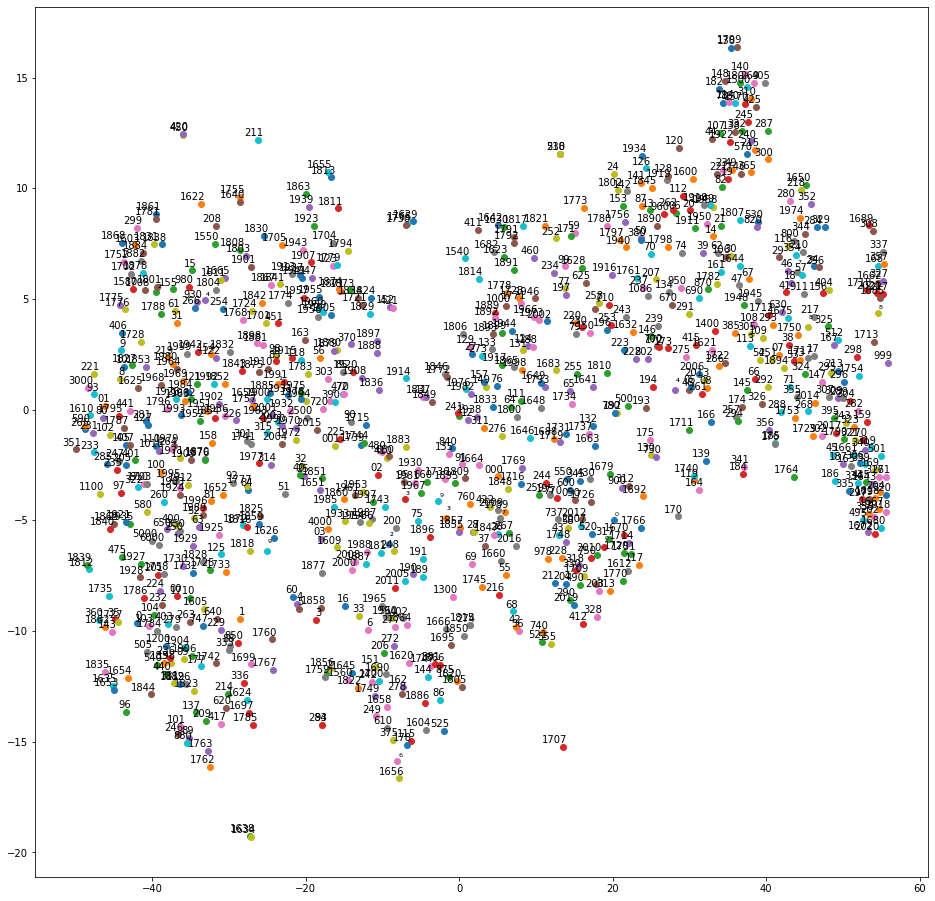

In [ ]:
bert_embeddings_plot(model=pretrained_bert_large, tokenizer=tokenizer_bert_large, word_list=numbers_in_bert_vocab)

In [110]:
def bert_partwise_similarity(pairs, model, tokenizer):
  for pair in pairs:
    embedding_pair = {}
    for sentance in pair:
      marked_text = "[CLS] " + sentance + " [SEP]"

      tokenized_text = tokenizer.tokenize(marked_text)
      indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
      segments_ids = [1] * len(tokenized_text)
      tokens_tensor = torch.tensor([indexed_tokens])
      segments_tensors = torch.tensor([segments_ids])

      with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

        token_vecs = hidden_states[-2][0]
        sentence_embedding = torch.mean(token_vecs, dim=0)
        embedding_pair[sentance] = sentence_embedding

    diff = 1 - cosine(embedding_pair[pair[0]].cpu(), embedding_pair[pair[1]].cpu())
    print(pair, diff)
  
def bert_partwise_similarity_list(pairs, model, tokenizer):
  relative_list = []
  num_of_pairs = 0
  for pair in pairs:
    num_of_pairs += 1
    if num_of_pairs % 100 == 0:
      print(num_of_pairs, "/", len(pairs))
    embedding_pair = {}
    for sentance in pair:
      marked_text = "[CLS] " + sentance + " [SEP]"

      tokenized_text = tokenizer.tokenize(marked_text)
      indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
      segments_ids = [1] * len(tokenized_text)
      tokens_tensor = torch.tensor([indexed_tokens])
      segments_tensors = torch.tensor([segments_ids])

      with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]

        token_vecs = hidden_states[-2][0]
        sentence_embedding = torch.mean(token_vecs, dim=0)
        embedding_pair[sentance] = sentence_embedding

    diff = 1 - cosine(embedding_pair[pair[0]].cpu(), embedding_pair[pair[1]].cpu())
    relative_list.append([pair[1], diff])
  return relative_list

In [ ]:
numbers_in_bert_vocab_pairs = list(itertools.combinations(numbers_in_bert_vocab[:5], 2))
bert_partwise_similarity(numbers_in_bert_vocab_pairs, pretrained_bert_large, tokenizer_bert_large)

('0', '1') 0.776008129119873
('0', '2') 0.7700493335723877
('0', '3') 0.7682870030403137
('0', '4') 0.7681866884231567
('1', '2') 0.9300211668014526
('1', '3') 0.9164273738861084
('1', '4') 0.8903205990791321
('2', '3') 0.960974931716919
('2', '4') 0.9422019720077515
('3', '4') 0.974308431148529


In [ ]:
list_of_numbers_relative_to_one = bert_partwise_similarity_list([["1", n] for n in numbers_in_bert_vocab], pretrained_bert_large, tokenizer_bert_large)

100 / 881
200 / 881
300 / 881
400 / 881
500 / 881
600 / 881
700 / 881
800 / 881


In [ ]:
print(list_of_numbers_relative_to_one)
list_of_numbers_relative_to_one.sort(key=lambda x: x[1])

[['0', 0.776008129119873], ['1', 1.0], ['2', 0.9300211668014526], ['3', 0.9164273738861084], ['4', 0.8903205990791321], ['5', 0.9107829332351685], ['6', 0.898175060749054], ['7', 0.9128917455673218], ['8', 0.8972564339637756], ['9', 0.8662514090538025], ['²', 0.7537937164306641], ['³', 0.8052515387535095], ['¹', 0.792286217212677], ['⁰', 0.873949408531189], ['⁴', 0.7884066104888916], ['⁵', 0.786724865436554], ['⁶', 0.8548523187637329], ['⁷', 0.8830470442771912], ['⁸', 0.8863843083381653], ['⁹', 0.8687853217124939], ['₀', 0.8748788833618164], ['₁', 0.8320733904838562], ['₂', 0.8380435109138489], ['₃', 0.8825473189353943], ['₄', 0.8760560750961304], ['₅', 0.8821969032287598], ['₆', 0.8771417140960693], ['₇', 0.8851358294487], ['₈', 0.8858910202980042], ['₉', 0.8764832615852356], ['10', 0.8649129867553711], ['000', 0.8226302862167358], ['2010', 0.7920293211936951], ['2011', 0.7880505919456482], ['12', 0.8469974398612976], ['2012', 0.7856398224830627], ['2008', 0.7695408463478088], ['2009'

In [ ]:
list_of_numbers_relative_to_one.reverse()
berts_numbers = [i[0] for i in list_of_numbers_relative_to_one]


In [ ]:
print(berts_numbers)

['1', '2', '282', '307', '333', '287', '327', '385', '417', '334', '245', '306', '285', '175', '323', '335', '295', '65', '207', '134', '900', '313', '1697', '253', '325', '298', '1610', '525', '1773', '337', '317', '530', '183', '1705', '1713', '170', '381', '910', '1724', '263', '185', '930', '289', '430', '710', '3', '279', '238', '266', '189', '770', '304', '1842', '1703', '235', '262', '344', '247', '1714', '184', '108', '570', '555', '171', '1704', '050', '1603', '435', '296', '239', '151', '280', '730', '255', '179', '521', '219', '227', '288', '1826', '780', '242', '281', '1815', '254', '290', '7', '341', '326', '1675', '162', '338', '1626', '267', '240', '1634', '1692', '1683', '1803', '195', '1782', '318', '284', '760', '1913', '197', '1664', '560', '1757', '194', '1644', '700', '5', '345', '177', '237', '1785', '1699', '230', '1738', '1712', '1741', '1580', '1688', '490', '1611', '249', '495', '1767', '1781', '173', '1641', '1821', '178', '121', '164', '188', '336', '343', '

In [108]:
from collections import defaultdict
from matplotlib import animation
from IPython.display import HTML
from PIL import Image
from IPython.display import Image as display_image


def get_attention(model, tokenizer, sentence_a, sentence_b=None):
  is_sentence_pair = bool(sentence_b)

  # Prepare inputs to model
  tokens_a = None
  tokens_b = None
  token_type_ids = None
  if not is_sentence_pair:  # Single sentence
      tokens_a = [tokenizer.cls_token] + tokenizer.tokenize(sentence_a) + [tokenizer.sep_token]

  else:
      tokens_a = [tokenizer.cls_token] + tokenizer.tokenize(sentence_a) + [tokenizer.sep_token]
      tokens_b = tokenizer.tokenize(sentence_b) + [tokenizer.sep_token]
      token_type_ids = torch.LongTensor([[0] * len(tokens_a) + [1] * len(tokens_b)])
      
  token_ids = tokenizer.convert_tokens_to_ids(tokens_a + (tokens_b if tokens_b else []))
  tokens_tensor = torch.tensor(token_ids).unsqueeze(0)

  # Call model to get attention data
  # model.eval()
  if token_type_ids is not None:
      output = model(tokens_tensor, token_type_ids=token_type_ids)
  else:
      output = model(tokens_tensor)
  attn_data_list = output[-1]

  # Populate map with attn data and, optionally, query, key data
  attn_dict = defaultdict(list)
  print(attn_data_list)
 
def fig2data(fig):
  # draw the renderer
  fig.canvas.draw ( )

  # Get the RGBA buffer from the figure
  w,h = fig.canvas.get_width_height()
  buf = np.frombuffer(fig.canvas.tostring_argb(), dtype=np.uint8)
  buf.shape = ( w, h,4 )

  # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
  buf = np.roll ( buf, 3, axis = 2 )
  return buf

def fig2img(fig):
  buf = fig2data(fig)
  w, h, d = buf.shape
  return Image.frombytes( "RGBA", ( w ,h ), buf.tostring( ) )

def heatplot_attention(model, tokenizer, sentence, layer=None, save_gif=False):
  tks_ids = tokenizer.build_inputs_with_special_tokens(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)))
  tks = tokenizer.convert_ids_to_tokens(tks_ids)
  with torch.no_grad():
    _, _, attentions = model(torch.tensor(tks_ids).unsqueeze(0))
  
  attentions = torch.cat(attentions)

  fig = plt.figure(figsize=(20, 15))
  axes = []
  if not layer and save_gif:
    attention_layers = []
    for i_layer in range(12):
      for i_head in range(12):
        axes.append(fig.add_subplot(3, 4, 1 + i_head))
        axes[-1].set_title(f"Head {1 + i_layer}:{1 + i_head}")
        layers_heatmap = sns.heatmap(attentions[i_layer, i_head].cpu(), 
                    vmin=0, vmax=1, 
                    yticklabels=tks, xticklabels=tks, 
                    annot=False, ax=axes[-1], 
                    cbar=False,
                    fmt='04.2f')
      attention_layers.append(fig2img(layers_heatmap.get_figure()))
    attention_layers[0].save('attention.gif',
               save_all=True, append_images=attention_layers[1:], optimize=False, duration=500, loop=0)

  else:
    print(layer)
    for i_head in range(12):
      axes.append(fig.add_subplot(3, 4, 1 + i_head))
      axes[-1].set_title(f"Head {1 + layer}:{1 + i_head}")
      sns.heatmap(attentions[layer, i_head].cpu(), 
                  vmin=0, vmax=1, 
                  yticklabels=tks, xticklabels=tks, 
                  annot=False, ax=axes[-1], 
                  cbar=False,
                  fmt='04.2f')

    
def bipartite_attention(model, tokenizer, sentence, layer):
  tks_ids = tokenizer.build_inputs_with_special_tokens(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)))
  tks = tokenizer.convert_ids_to_tokens(tks_ids)
  with torch.no_grad():
    _, _, attentions = model(torch.tensor(tks_ids).unsqueeze(0))
  
  attentions = torch.cat(attentions)

  fig = plt.figure(figsize=(15,40))
  axes = []
  for i_head in range(12):
    attns = attentions[layer, i_head].cpu()
    # Matplotlib setup
    axes.append(fig.add_subplot(6, 2, 1 + i_head))
    axes[-1].set_title(f'Head {1 + layer}:{1 + i_head}')
    # Graph construction
    G = nx.DiGraph()
    top_node_labels, bottom_node_labels = zip(*tuple((f'{i} {tk}', f'{tk} {i}') 
                                              for i, tk in enumerate(tks)))
    G.add_nodes_from(top_node_labels, bipartite=0)
    G.add_nodes_from(bottom_node_labels, bipartite=1)
    G.add_weighted_edges_from([(tnl, bnl, weight) 
                              for tnl, row in zip(top_node_labels, attns) 
                              for bnl, weight in zip(bottom_node_labels, row)])
    edge_ws = np.array([G[u][v]['weight'] for u,v in G.edges()])
    # Graph plot
    nx.draw_networkx(G,
                    # bipartite layout 
                    pos={
                        **{tnl: (0, -i) for i, tnl in enumerate(top_node_labels)},
                        **{bnl: (1, -i) for i, bnl in enumerate(bottom_node_labels)}, 
                    },
                    # presentation options 
                    width=edge_ws * 3, edge_color=edge_ws, edge_cmap=plt.cm.afmhot_r, style='dotted',
                    edge_vmin=0, edge_vmax=1,
                    min_source_margin=20, min_target_margin=20,  
                    node_size=0, font_size=10, arrowsize=20,
                    ax=axes[-1])

In [95]:
%ls

attention_fast.gif.png  pillow_imagedraw.gif.png
attention.gif.png       sample_data/


In [94]:
%mv attention.gif attention.gif.png

In [ ]:
print(get_attention(model=pretrained_bert_large, tokenizer=tokenizer_bert_large, sentence_a='Apple stocks have icreased in value by 1 percent'))

In [ ]:
model_for_attention = BertModel.from_pretrained('bert-base-uncased', output_attentions=True)
tokenizer_for_attetion = BertTokenizer.from_pretrained('bert-base-uncased')

torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained_bert_large.to(device)
pretrained_bert_large.eval()

In [ ]:
my_stocks = [['Apple stocks have icreased in value by 1 percent', 
              'Apple stocks have dropped in value by 1 percent'], 
             ['Apple stocks have increased in value by 1 percent', 
              'Apple stocks have increased in value by 000,000,001 percent']]



bert_partwise_similarity(my_stocks, pretrained_bert_large, tokenizer_bert_large)

['Apple stocks have icreased in value by 1 percent', 'Apple stocks have dropped in value by 1 percent'] 0.9563276767730713
['Apple stocks have increased in value by 1 percent', 'Apple stocks have increased in value by 000,000,001 percent'] 0.9488617777824402


In [ ]:
bert_partwise_similarity([["4", "four"], ["5", "five"], ["4", "5"], ["four", "five"]], pretrained_bert_large, tokenizer_bert_large)

['4', 'four'] 0.7949143648147583
['5', 'five'] 0.8862231373786926
['4', '5'] 0.9677941799163818
['four', 'five'] 0.9097074270248413


In [ ]:
heatplot_attention(model=model_for_attention, tokenizer=tokenizer_for_attetion, sentence='Apple stocks have increased in value by 1 percent', save_gif=True)
%mv attention.gif attention.gif.png

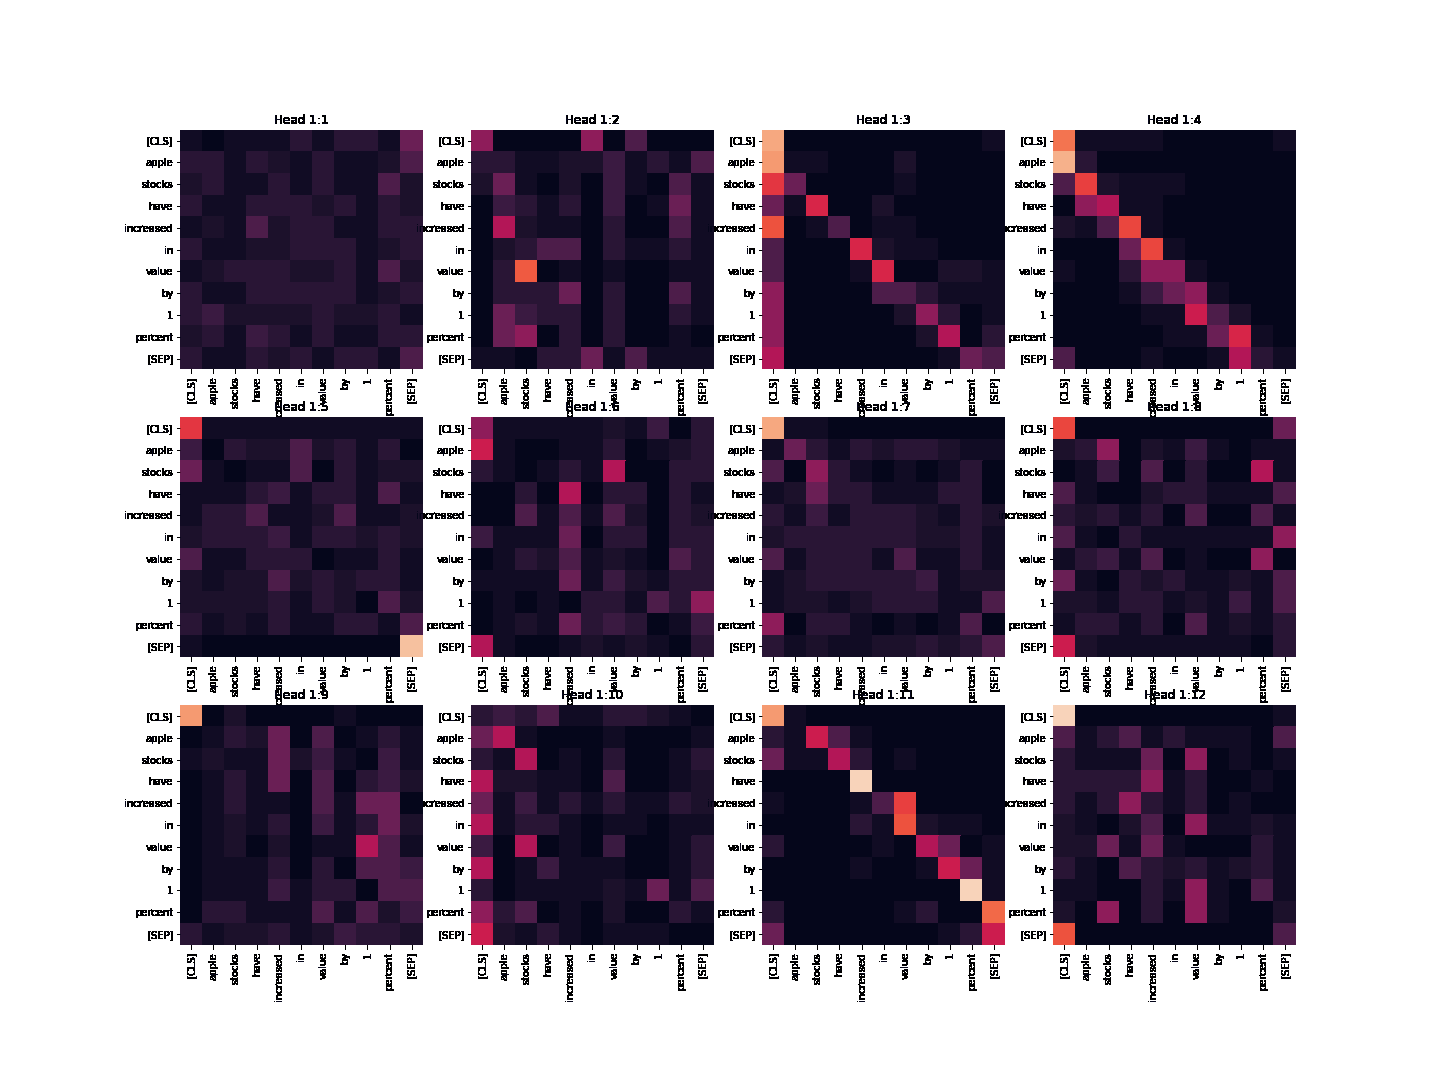

In [103]:
display_image(filename="attention.gif.png")

0


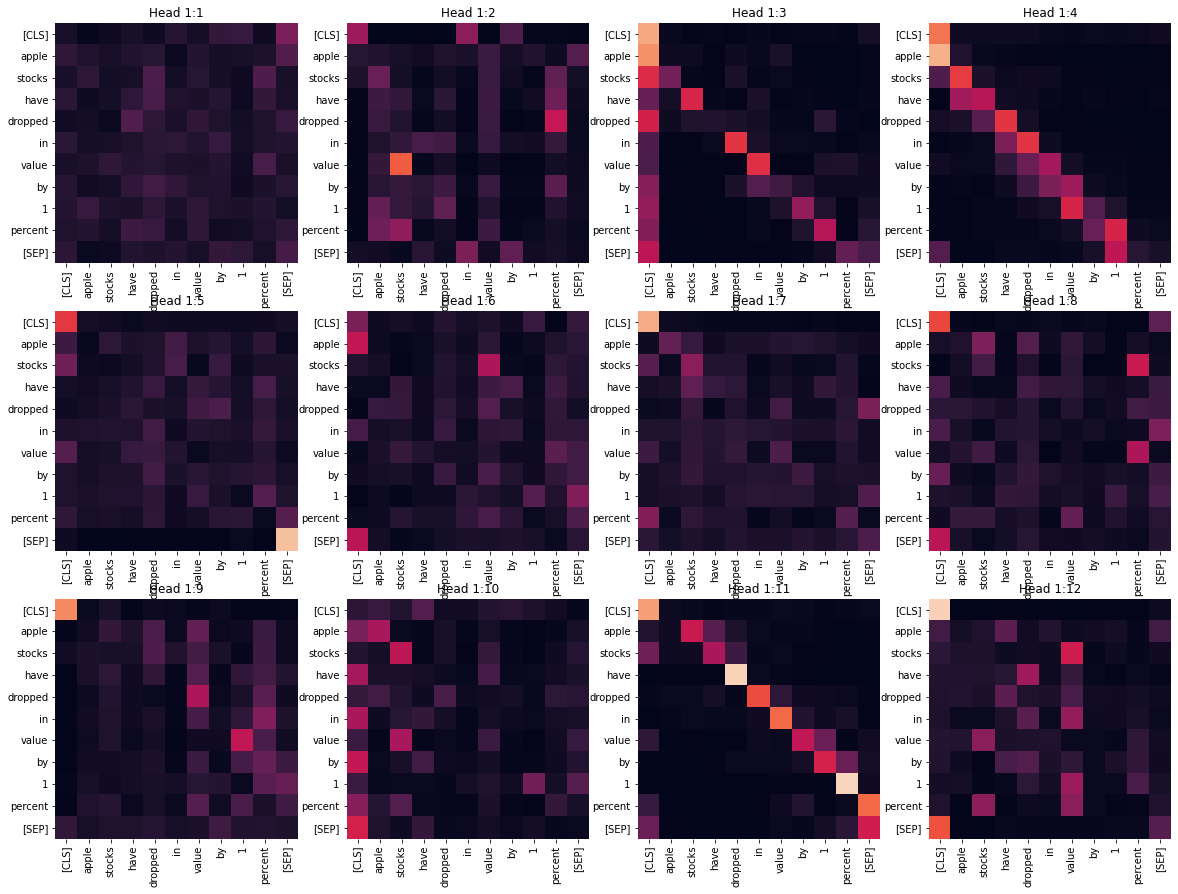

In [109]:
heatplot_attention(model=model_for_attention, tokenizer=tokenizer_for_attetion, sentence='Apple stocks have dropped in value by 1 percent', layer=0)

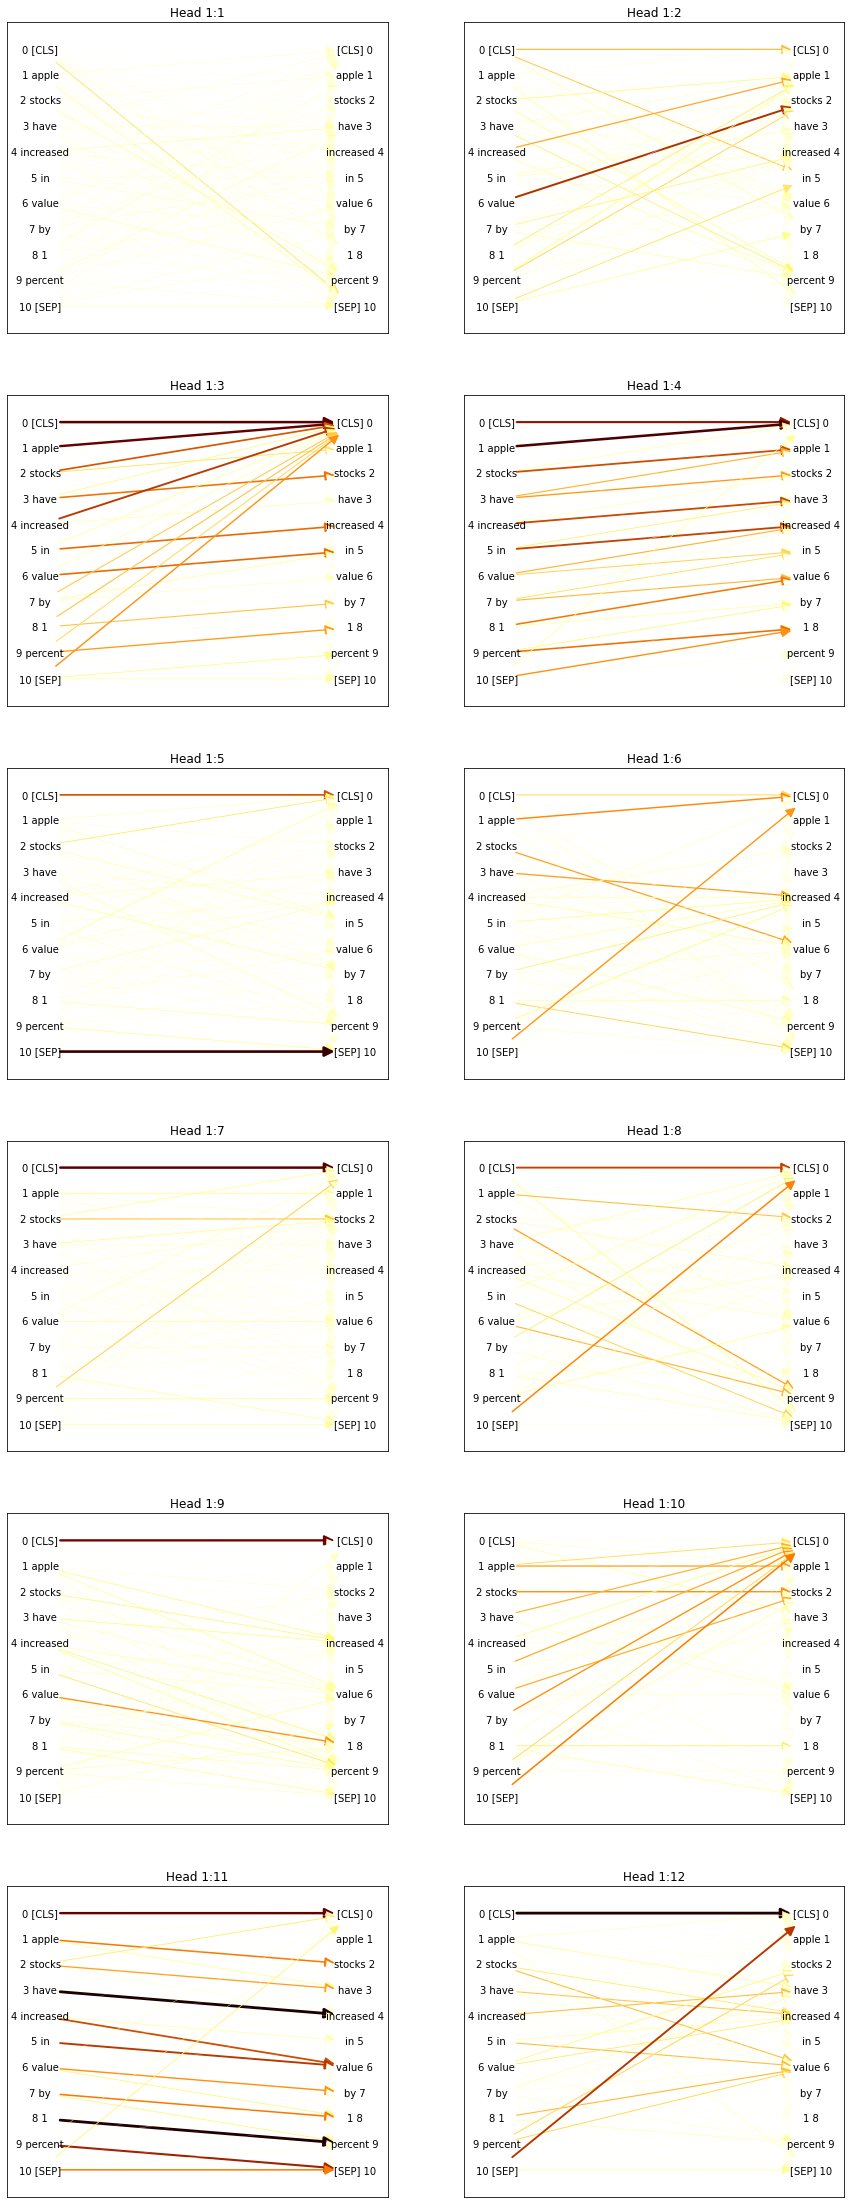

In [ ]:
bipartite_attention(model=model_for_attention, tokenizer=tokenizer_for_attetion, sentence='Apple stocks have increased in value by 1 percent', layer=0)

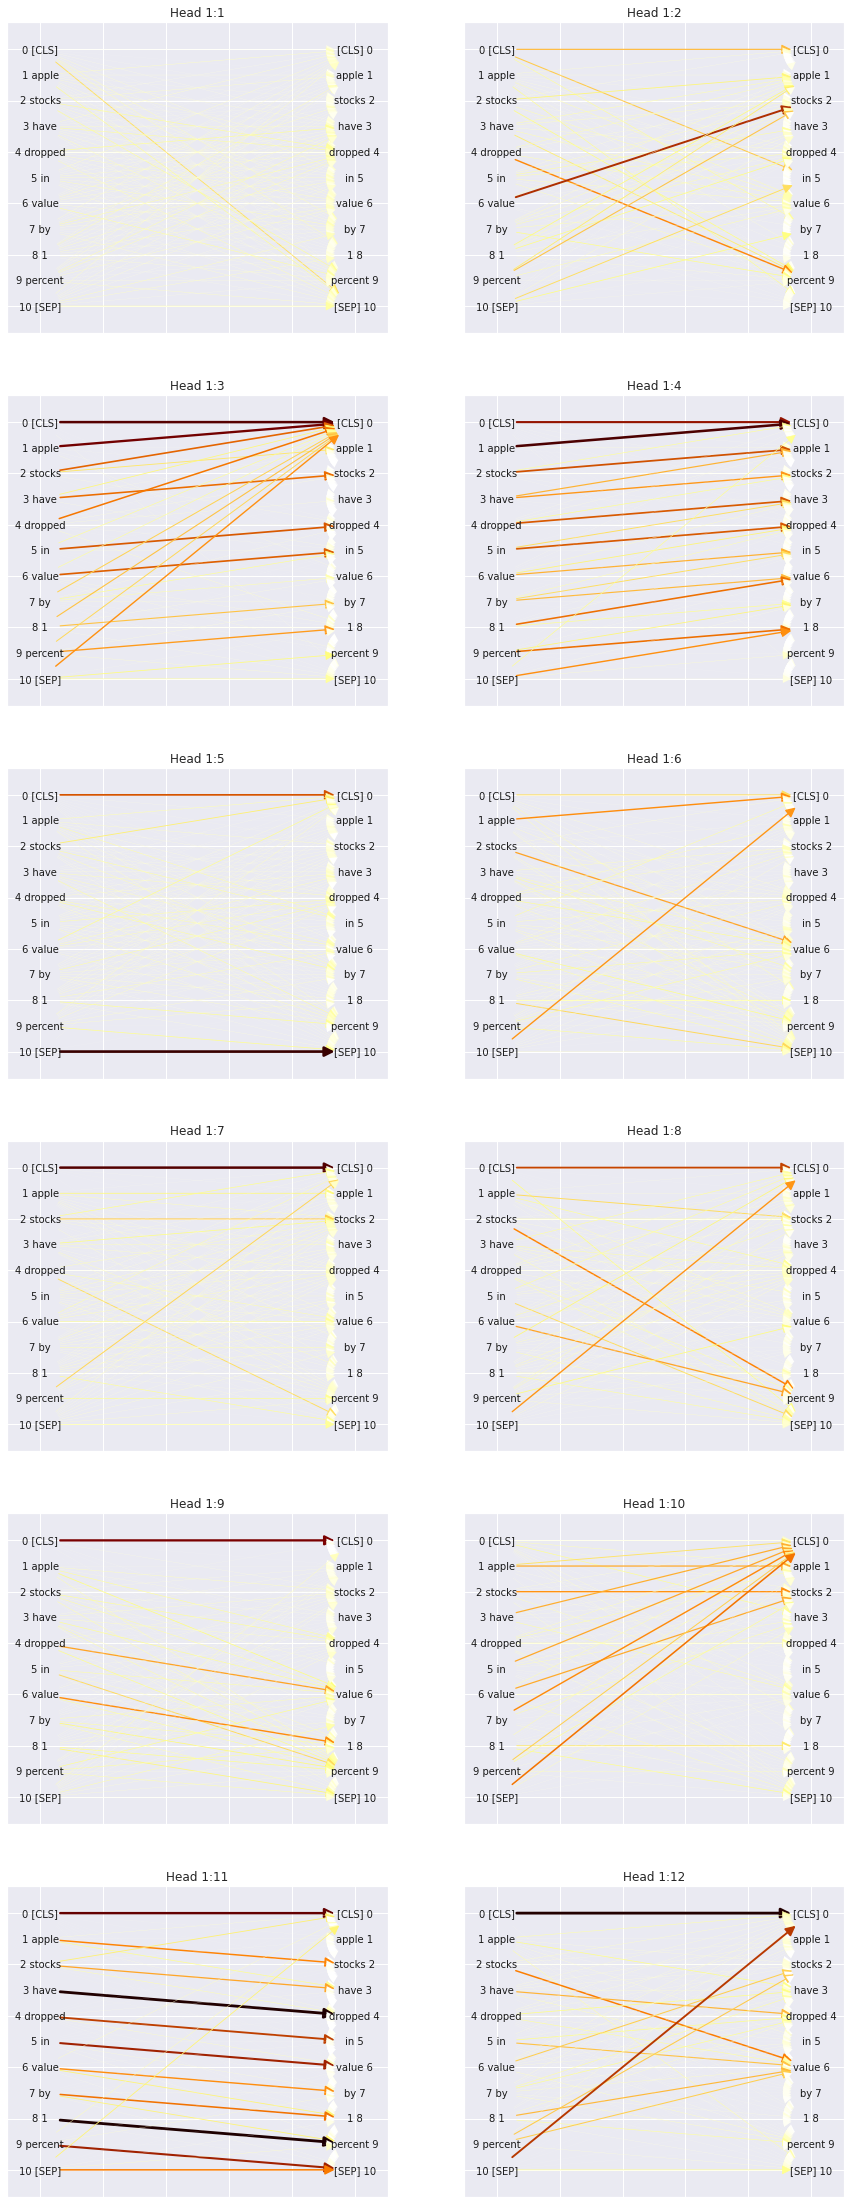

In [ ]:
bipartite_attention(model=model_for_attention, tokenizer=tokenizer_for_attetion, sentence='Apple stocks have dropped in value by 1 percent', layer=0)

Let's look at Dyscalculia Symptom Test for Children. See if BERT has Dyscalculia.

Let's look at some questions from the test:

1. Does your child not seem to understand the connection between the symbol “4” and the word “four?” Does he make mistakes when reading or following directions involving number words and symbols?

In [ ]:
dscalculia_symbol_word = [['I have 4 apples', 
              'I have four apples'], 
             ['I have 4 apples', 
              'I have 5 apples']]

bert_partwise_similarity(dscalculia_symbol_word, pretrained_bert_large, tokenizer_bert_large)

['I have 4 apples', 'I have four apples'] 0.9395034909248352
['I have 4 apples', 'I have 5 apples'] 0.9895713925361633


2. Does your child say numbers out of order?

mmm, clearly, as seen from the numbers that are close to one: '1', '2', '282', '307', '333', '287' ...

3. Does your child not seem to understand the difference between adding and subtracting? Does she confuse the + and – symbols when completing math problems?

In [ ]:
bert_partwise_similarity([["+", "-"], ["+", "*"], ["+", "add"]], pretrained_bert_large, tokenizer_bert_large)

['+', '-'] 0.6966980695724487
['+', '*'] 0.8616664409637451
['+', 'add'] 0.8443118333816528


BERT undertanda that + and - are different 

4. Does your child have difficulty applying fractions to real-world objects? Is he/she unable to determine that a dollar equals four quarters, for instance, or that one-half of the year is equal to six months?

In [ ]:
bert_partwise_similarity([["a dollar", "four quarters"], ["a dollar", "five quarters"], ["one-half of the year", "six months"], ["one-half of the year", "three months"]], pretrained_bert_large, tokenizer_bert_large)

['a dollar', 'four quarters'] 0.7773893475532532
['a dollar', 'five quarters'] 0.7972930073738098
['one-half of the year', 'six months'] 0.7877083420753479
['one-half of the year', 'three months'] 0.799160361289978


In [ ]:
from transformers import BertForQuestionAnswering, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [ ]:
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12,

In [ ]:
print(device)
torch.set_default_tensor_type('torch.cuda.FloatTensor')

cuda:0


In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (16,8)

def compute_softmax(scores):
    """Compute softmax probability over raw logits."""
    if not scores:
        return []

    max_score = None
    for score in scores:
        if max_score is None or score > max_score:
            max_score = score

    exp_scores = []
    total_sum = 0.0
    for score in scores:
        x = math.exp(score - max_score)
        exp_scores.append(x)
        total_sum += x

    probs = []
    for score in exp_scores:
        probs.append(score / total_sum)
    return probs

def visualize_bert_for_qa(question, answer_text, model, tokenizer):
  input_ids = tokenizer.encode(question, answer_text)
  tokens = tokenizer.convert_ids_to_tokens(input_ids) 
  sep_index = input_ids.index(tokenizer.sep_token_id)
  num_seg_a = sep_index + 1
  num_seg_b = len(input_ids) - num_seg_a
  segment_ids = [0]*num_seg_a + [1]*num_seg_b
  assert len(segment_ids) == len(input_ids)

  start_scores, end_scores = model(torch.tensor([input_ids]),
                                 token_type_ids=torch.tensor([segment_ids])) 
  answer_start = torch.argmax(start_scores)
  answer_end = torch.argmax(end_scores)

  answer = ' '.join(tokens[answer_start:answer_end+1])
  print("Answer: ", answer)

  s_scores = start_scores.detach().cpu().numpy().flatten()
  e_scores = end_scores.detach().cpu().numpy().flatten()
  token_labels = []
  for (i, token) in enumerate(tokens):
      token_labels.append('{:} - {:>2}'.format(token, i))
  ax = sns.barplot(x=token_labels, y=s_scores, ci=None)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
  ax.grid(True)
  plt.title('Start Word Scores')
  plt.show()

def get_best_answer_probs(question, answer_text, model, tokenizer):
  input_ids = tokenizer.encode(question, answer_text)
  tokens = tokenizer.convert_ids_to_tokens(input_ids) 
  sep_index = input_ids.index(tokenizer.sep_token_id)
  num_seg_a = sep_index + 1
  num_seg_b = len(input_ids) - num_seg_a
  segment_ids = [0]*num_seg_a + [1]*num_seg_b
  assert len(segment_ids) == len(input_ids)

  start_scores, end_scores = model(torch.tensor([input_ids]),
                                 token_type_ids=torch.tensor([segment_ids])) 
  answer_start = torch.argmax(start_scores)
  answer_end = torch.argmax(end_scores)

  answer = ' '.join(tokens[answer_start:answer_end+1])
  print("Answer: ", answer)

  s_scores = start_scores.detach().cpu().numpy().flatten()
  e_scores = end_scores.detach().cpu().numpy().flatten()
  # print(s_scores)
  # print(e_scores)

  total_scores = []
  for score in range(len(s_scores)):
    total_scores.append(s_scores[score] + e_scores[score])
    print(score, s_scores[score] + e_scores[score])

  probs = compute_softmax(total_scores)

  results = []
  for token in range(len(tokens)):
    results.append({"score": s_scores[token] + e_scores[token], "probability": probs[token], "token":token})
    if token == answer_start:
      results.append({"score": s_scores[token] + e_scores[token], "probability": probs[token], "token": answer})
  return results

def get_best_answer_score(question, answer_text, model, tokenizer):
  input_ids = tokenizer.encode(question, answer_text)
  tokens = tokenizer.convert_ids_to_tokens(input_ids) 
  sep_index = input_ids.index(tokenizer.sep_token_id)
  num_seg_a = sep_index + 1
  num_seg_b = len(input_ids) - num_seg_a
  segment_ids = [0]*num_seg_a + [1]*num_seg_b
  assert len(segment_ids) == len(input_ids)

  start_scores, end_scores = model(torch.tensor([input_ids]),
                                 token_type_ids=torch.tensor([segment_ids])) 
  answer_start = torch.argmax(start_scores)
  answer_end = torch.argmax(end_scores)

  answer = ' '.join(tokens[answer_start:answer_end+1])
  s_scores = start_scores.detach().cpu().numpy().flatten()
  e_scores = end_scores.detach().cpu().numpy().flatten()

  for token in range(len(tokens)):
    if token == answer_start:
      return {"score": s_scores[token] + e_scores[token], "answer": answer}


Now let's see how BERT will solve first-grade-level math problems

{'score': 0.19023328761958216, 'start': 314, 'end': 329, 'answer': '19.'}
Answer:  


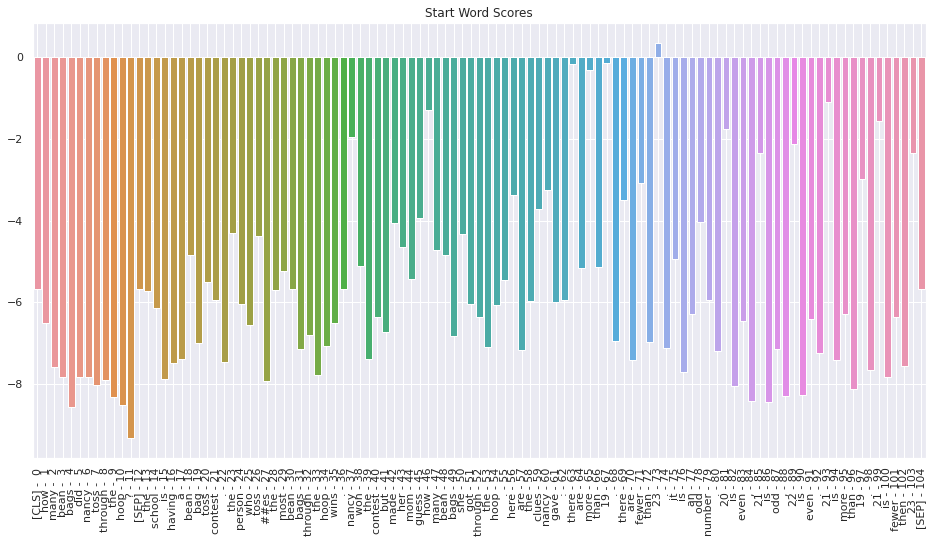

In [ ]:
from transformers import pipeline

nlp = pipeline('question-answering')

question = "How many bean bags did Nancy toss through the hoop?"
context = """
            The school is having a bean bag toss contest. 
            The person who tosses the most bean bags through the hoop wins.
            Nancy won the contest but made her mom guess how many bean bags she got through the hoop. 
            Here are the clues Nancy gave:
            There are more than 19.
            There are fewer than 23.
            It is an odd number.
            20 is even, 21 is odd, 22 is even.
            21 is more than 19. 21 is fewer then 23"""

output = nlp(question = question, context = context)

print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

{'score': 0.32921739525794436, 'start': 152, 'end': 155, 'answer': 'one'}
Answer:  one


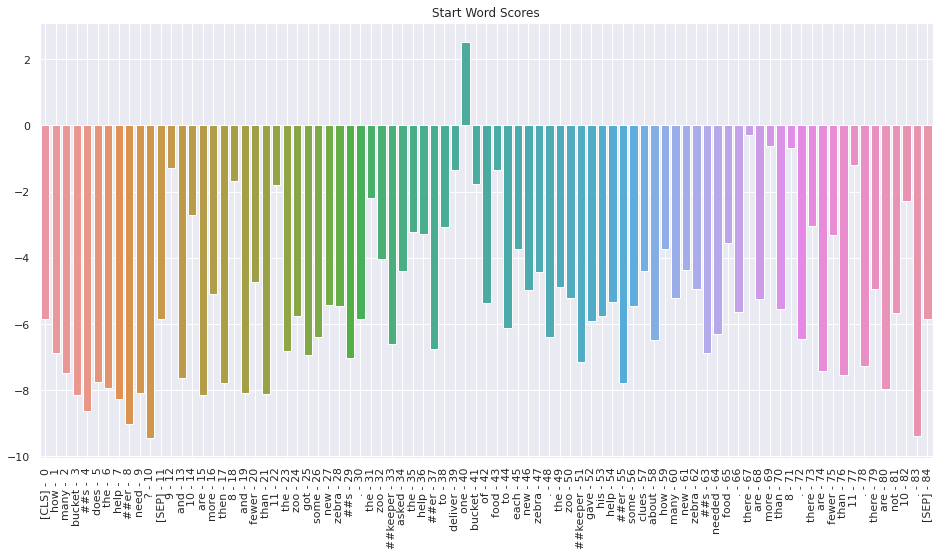

In [ ]:
question = "How many buckets does the helper need?"
context = """
            9 and 10 are more then 8 and fewer than 11
            The zoo got some new zebras.
             The zookeeper asked the helper to deliver one bucket of food to each new zebra. 
             The zookeeper gave his helper some clues about how many new zebras needed food. 
             There are more than 8.
             There are fewer than 11.
             There are not 10.
             """

output = nlp(question = question, context = context)

print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

{'score': 0.01485715104377097, 'start': 211, 'end': 225, 'answer': '4.'}
Answer:  4


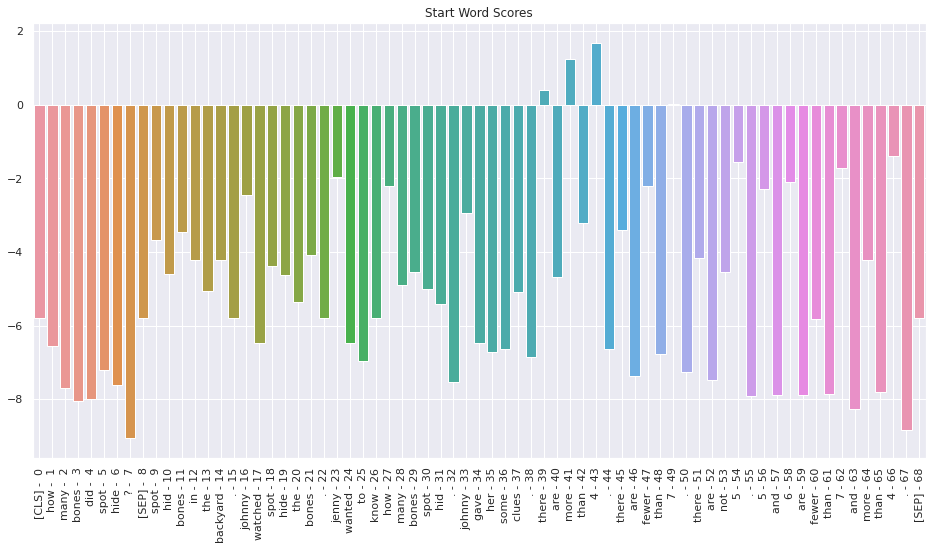

{'score': 0.012212091066622025, 'start': 212, 'end': 226, 'answer': '7.'}
Answer:  7


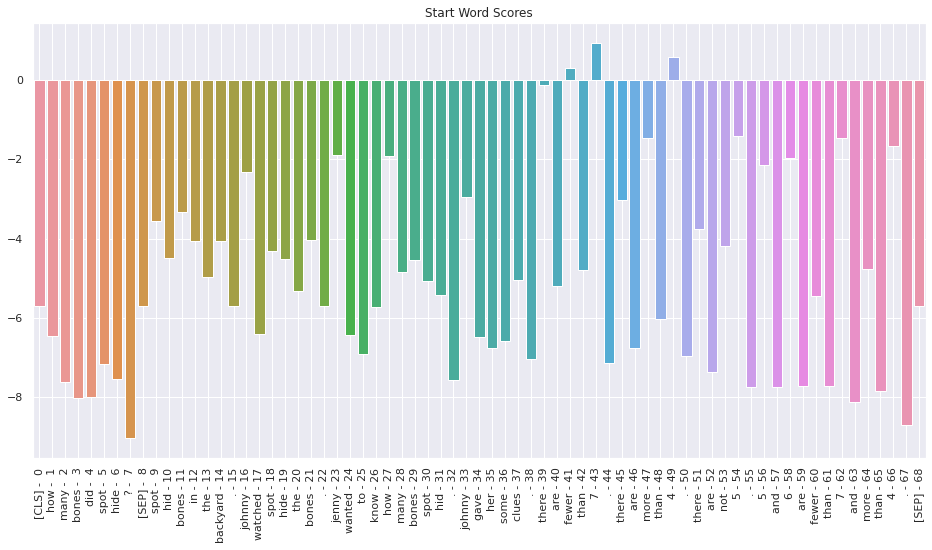

Answer:  5 and 6 are fewer than 7 and more than 4


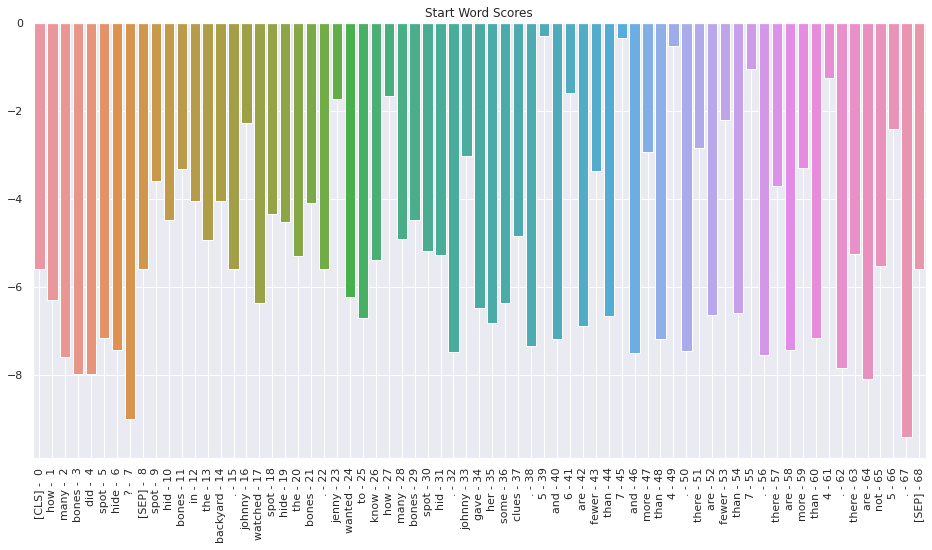

{'score': 0.0027135055432900845, 'start': 44, 'end': 121, 'answer': 'Johnny watched spot hide the bones. Jenny wanted to know how many'}


In [ ]:
question = "How many bones did Spot hide?"
context = """Spot hid bones in the backyard.
            Johnny watched spot hide the bones.
            Jenny wanted to know how many bones Spot hid.
            Johnny gave her some clues. 
            There are more than 4.
            There are fewer than 7.
            There are not 5.
            5 and 6 are fewer than 7 and more than 4."""

output = nlp(question = question, context = context)

print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

context = """Spot hid bones in the backyard.
            Johnny watched spot hide the bones.
            Jenny wanted to know how many bones Spot hid.
            Johnny gave her some clues. 
            There are fewer than 7.
            There are more than 4.
            There are not 5.
            5 and 6 are fewer than 7 and more than 4."""


output = nlp(question = question, context = context)

print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

context = """Spot hid bones in the backyard.
            Johnny watched spot hide the bones.
            Jenny wanted to know how many bones Spot hid.
            Johnny gave her some clues. 
            5 and 6 are fewer than 7 and more than 4.
            There are fewer than 7.
            There are more than 4.
            There are not 5.
            """


output = nlp(question = question, context = context)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

print(output)

Answer:  2


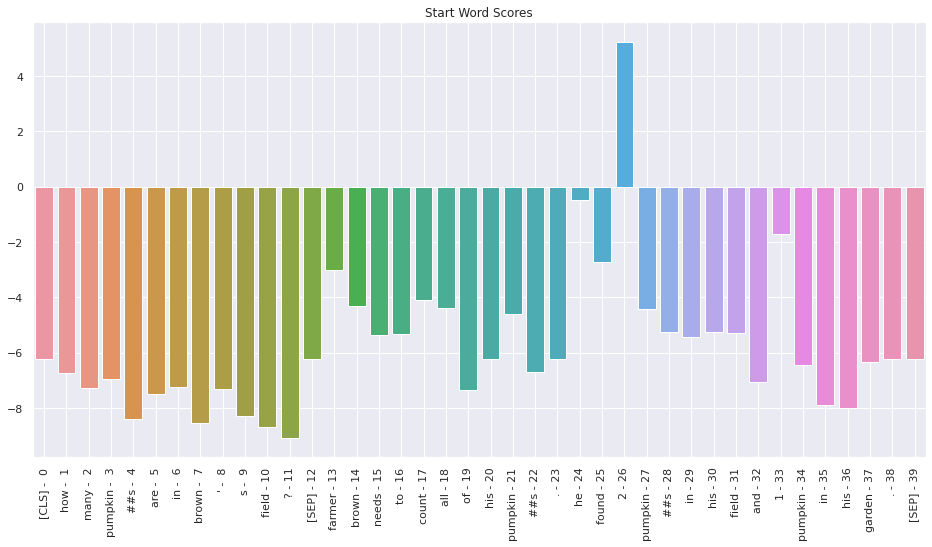

{'score': 0.9327997989793236, 'start': 59, 'end': 60, 'answer': '2'}
Answer:  1


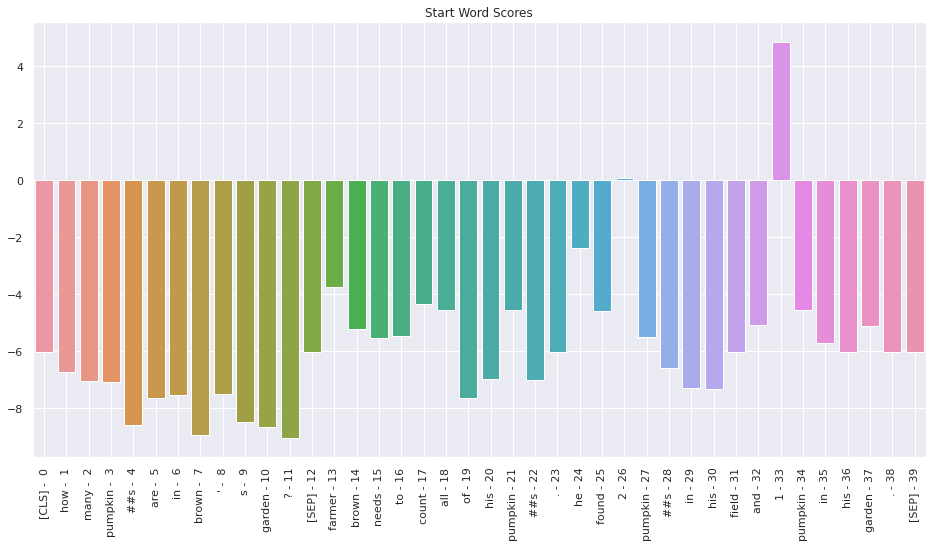

{'score': 0.9696876208245977, 'start': 87, 'end': 88, 'answer': '1'}
Answer:  2


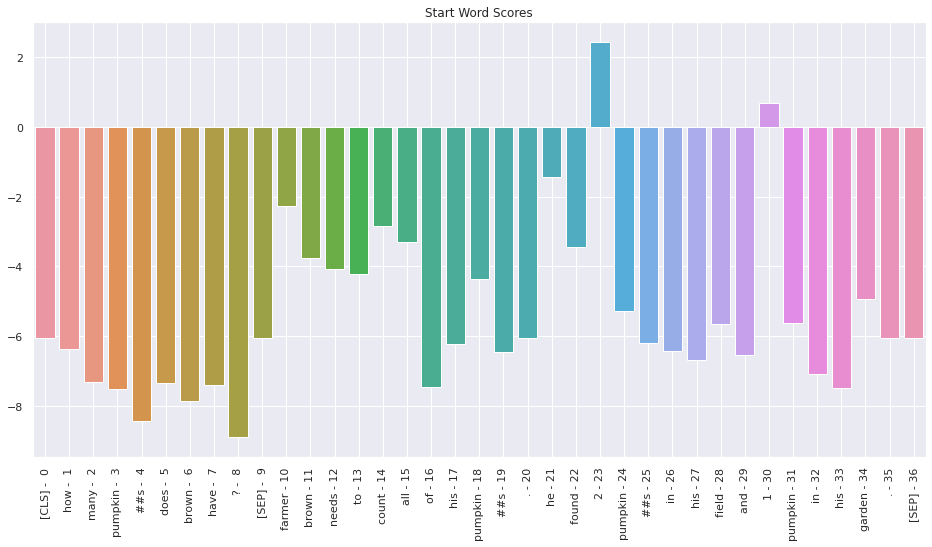

{'score': 0.3309935490012853, 'start': 59, 'end': 60, 'answer': '2'}


In [ ]:
question = "How many pumpkins are in Brown's field?"
context = """Farmer Brown needs to count all of his pumpkins.  He found 2 pumpkins in his field and 1 pumpkin in his garden."""
output = nlp(question = question, context = context)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)
print(output)

question = "How many pumpkins are in Brown's garden?"
output = nlp(question = question, context = context)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)
print(output)

question = "How many pumpkins does Brown have?"
output = nlp(question = question, context = context)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)
print(output)

{'score': 0.880505238436541, 'start': 100, 'end': 102, 'answer': '14'}
Answer:  14


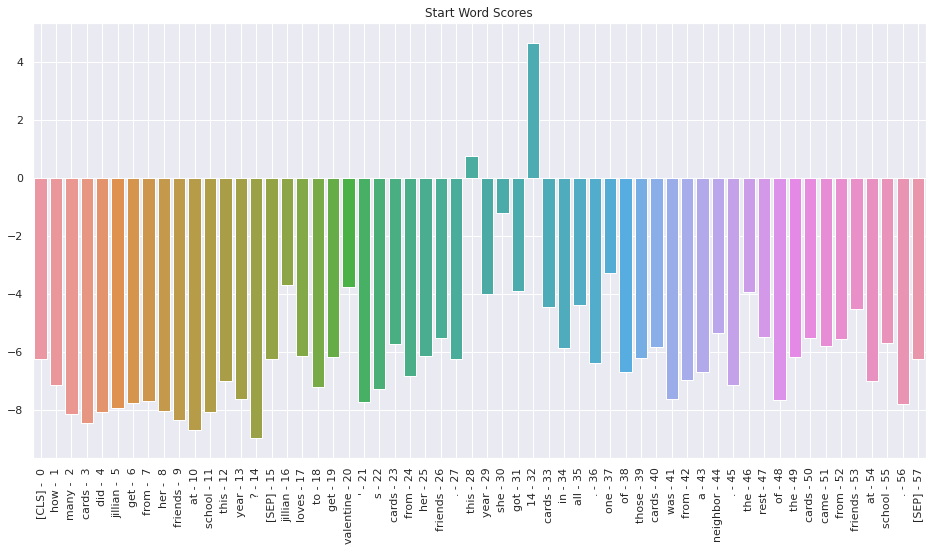

In [ ]:
question = "How many cards did Jillian get from her friends at school this year?"
context = """
            Jillian loves to get Valentine's cards from her friends.
            This year she got 14 cards in all.  One of those cards was from a neighbor.
            The rest of the cards came from friends at school.
            """
output = nlp(question = question, context = context)
print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)


{'score': 0.8270043782307287, 'start': 21, 'end': 28, 'answer': 'Eugene'}
Answer:  eugene


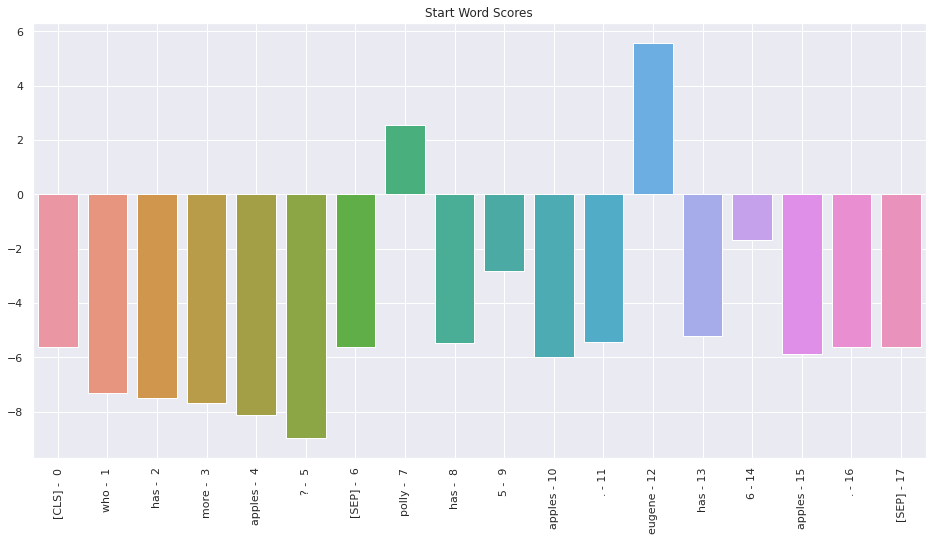

In [ ]:
question = "Who has more apples?"
context = """Polly has 5 apples.  Eugene  has 6 apples.
            """
output = nlp(question = question, context = context)
print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

Answer:  eugene


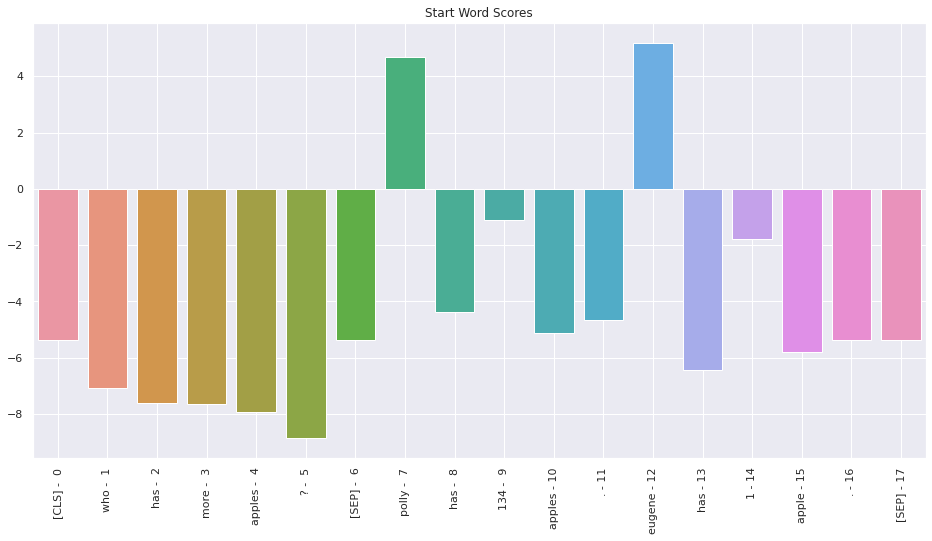

In [ ]:
question = "Who has more apples?"
context = """Polly has 134 apples.  Eugene  has 1 apple.
            """

visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

Answer:  polly


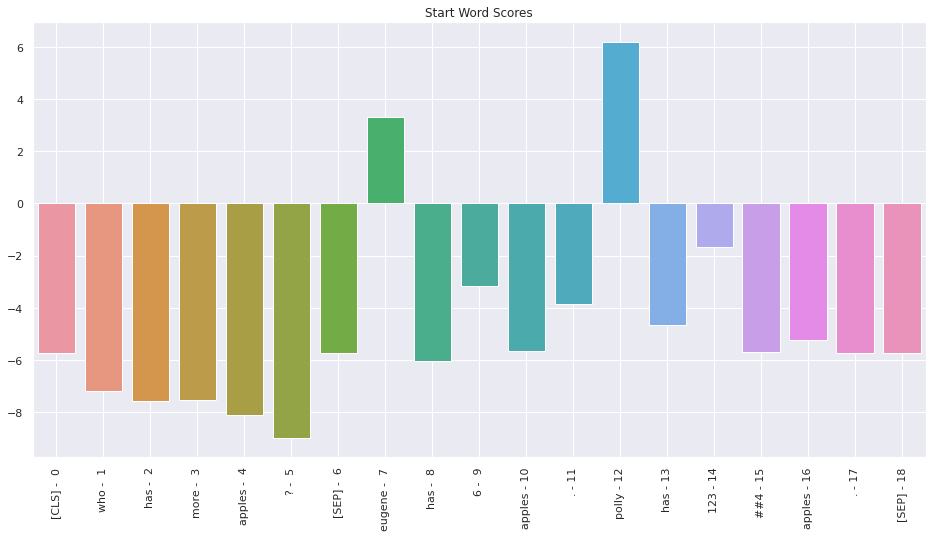

In [ ]:
question = "Who has more apples?"
context = """ Eugene  has 6 apples. Polly has 1234 apples. 
            """
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

{'score': 0.4433372447069095, 'start': 32, 'end': 37, 'answer': 'Polly'}
Answer:  polly


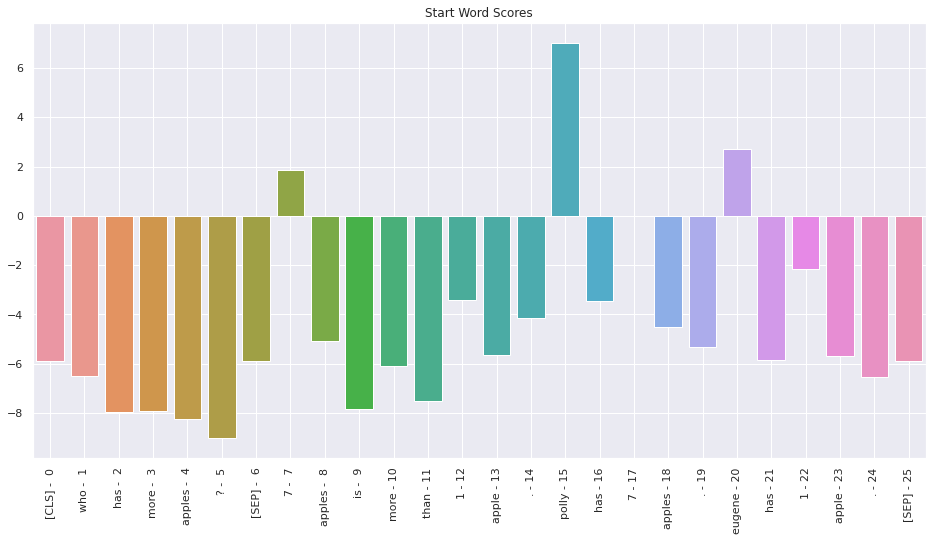

In [ ]:
question = "Who has more apples?"
context = """ 7 apples is more than 1 apple. Polly has 7 apples.  Eugene  has 1 apple.
            """
output = nlp(question = question, context = context)
print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

Answer:  eugene


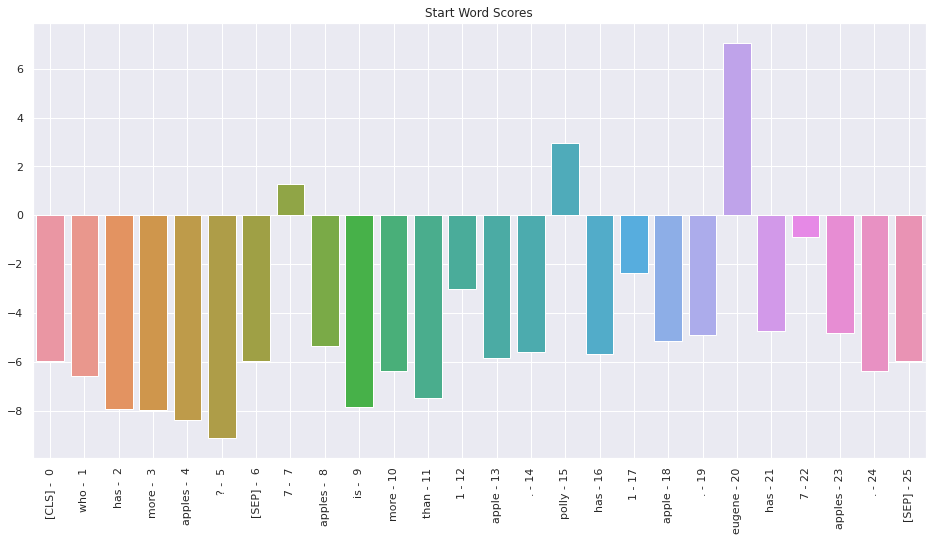

In [ ]:
question = "Who has more apples?"
context = """ 7 apples is more than 1 apple.  Polly  has 1 apple. Eugene has 7 apples.
            """
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

{'score': 0.33768809181739795, 'start': 53, 'end': 60, 'answer': 'Eugene'}
Answer:  polly


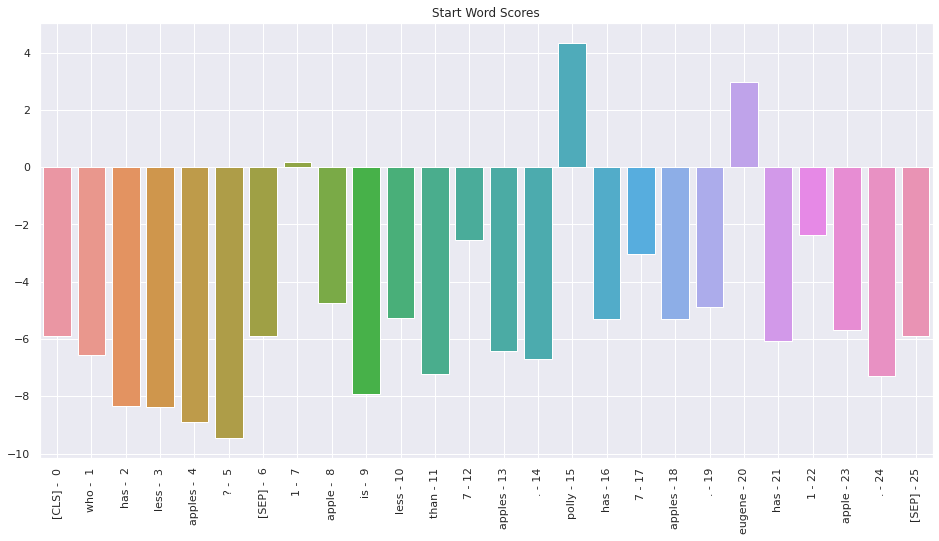

In [ ]:
question = "Who has less apples?"
context = """ 1 apple is less than 7 apples. Polly has 7 apples.  Eugene  has 1 apple.
            """
output = nlp(question = question, context = context)
print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

Maybe logical problems will be better.

{'score': 0.12470289827380034, 'start': 28, 'end': 35, 'answer': 'William'}
Answer:  michael


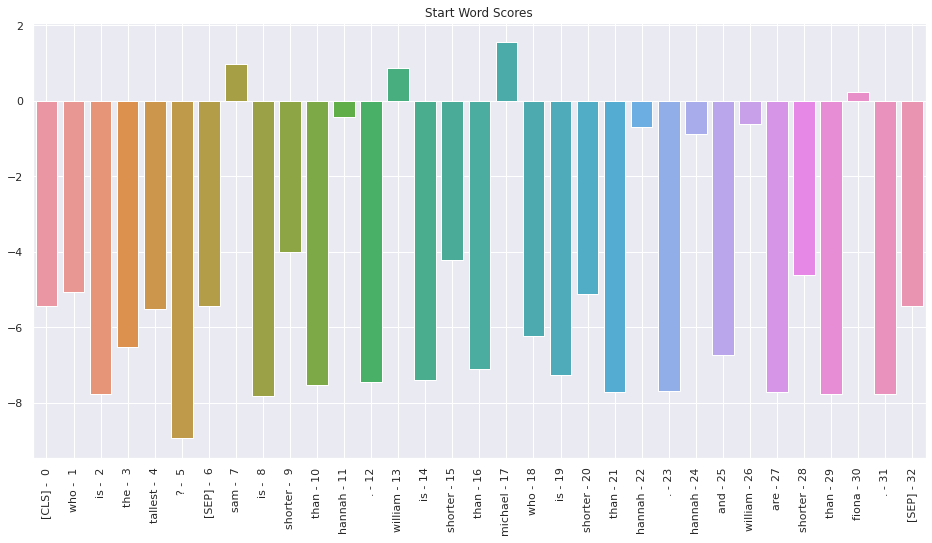

In [ ]:
bert_partwise_similarity(my_stocks, pretrained_bert_large, tokenizer_bert_large)question = " Who is the tallest?"
context = """Sam is shorter than Hannah. William is shorter than Michael who is shorter than Hannah. Hannah and William are shorter than Fiona."""
# correct answer: Fiona
output = nlp(question = question, context = context)
print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

{'score': 0.5395204061181245, 'start': 19, 'end': 25, 'answer': 'Sharon'}
Answer:  ben


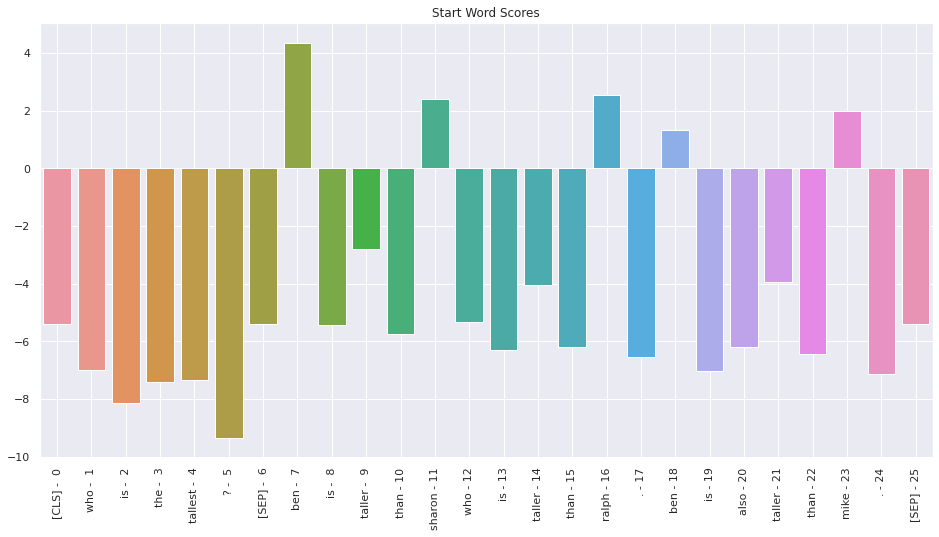

In [ ]:
question = "Who is the tallest?"
context = """Ben is taller than Sharon who is taller than Ralph. Ben is also taller than Mike."""
# correct answer: Ben
output = nlp(question = question, context = context)
print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

{'score': 0.9710372196627525, 'start': 15, 'end': 33, 'answer': 'wings.'}
Answer:  wings


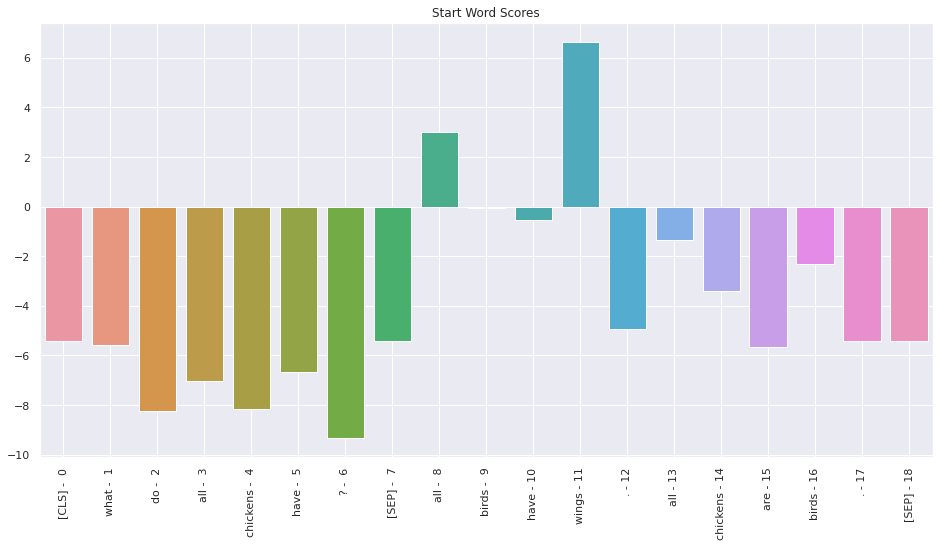

In [ ]:
question = "What do all chickens have?"
context = """all birds have wings.
            All chickens are birds. """
# correct answer: wings
output = nlp(question = question, context = context)
print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

{'score': 0.6224287766746227, 'start': 65, 'end': 74, 'answer': 'expensive.'}
Answer:  expensive


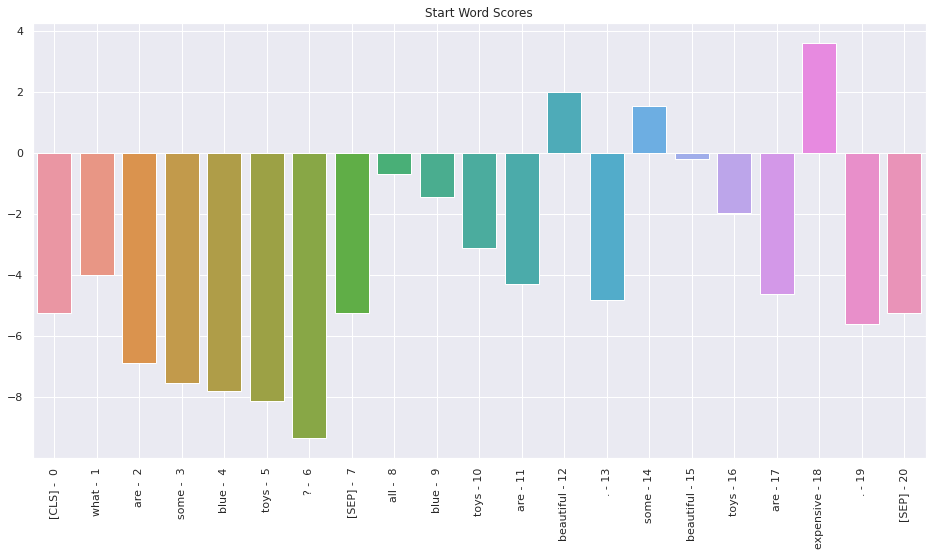

In [ ]:
question = "What are some blue toys?"
context = """All blue toys are beautiful.
            Some beautiful toys are expensive."""
# correct answer: expensive
output = nlp(question = question, context = context)
print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

{'score': 0.9331393026350289, 'start': 25, 'end': 34, 'answer': 'punished.'}
Answer:  punished


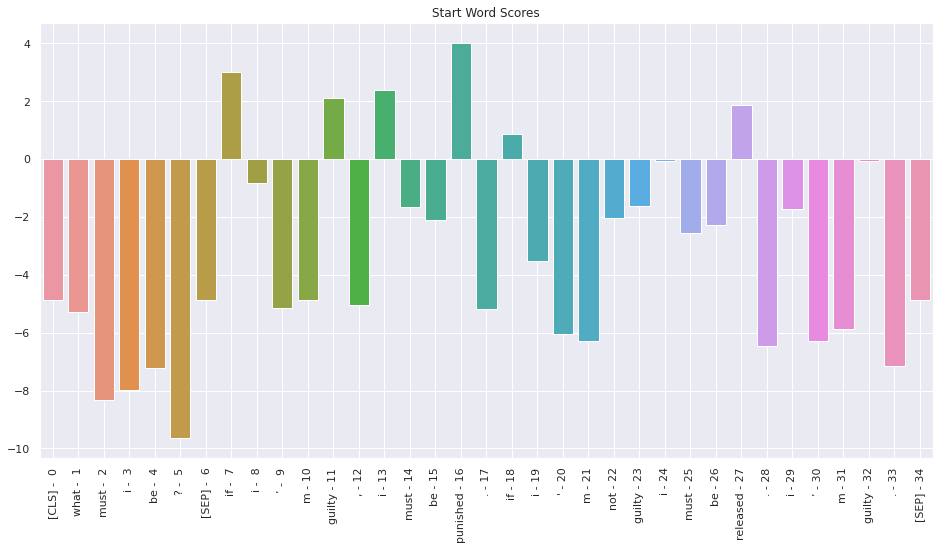

{'score': 0.5733123971659878, 'start': 63, 'end': 72, 'answer': 'released.'}
Answer:  released


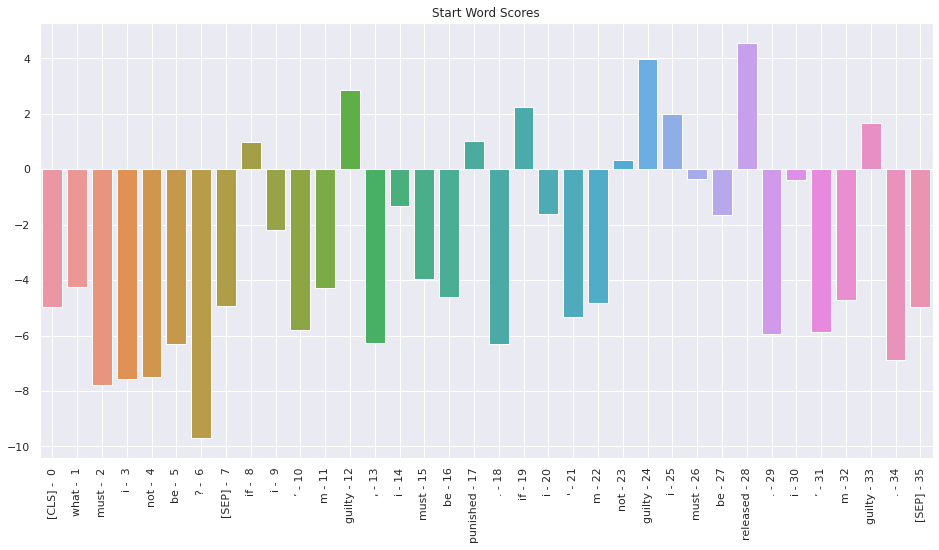

In [ ]:
question = "What must I be?"
context = """If I’m guilty, I must be punished. If I'm not guilty I must be released. I’m guilty."""
# correct answer: punished
output = nlp(question = question, context = context)
print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

question = "What must I not be?"
output = nlp(question = question, context = context)
print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

And for the last one let's do my favourite simple mathematical logic problem.

Aladdin finds two trunks A and B in a cave. 
            He knows that each of them either contains a treasure or a fatal trap.
            On trunk A is written: “ At least one of these two trunks contains atreasure.”
            On trunk B is written: “ In A there’s a fatal trap.”
            Aladdin knows that either both the inscriptions are true, or they are both false.
Which trunk should he open?

The solution goes like:
At least one of these two trunks contains a treasure.
Acontains a trap
either both the inscriptions are true, or they are both false
Aladdin can open trunk B, being sure that it contains a treasure


{'score': 0.3086763119431441, 'start': 143, 'end': 150, 'answer': 'trunk A'}
Answer:  trunk a


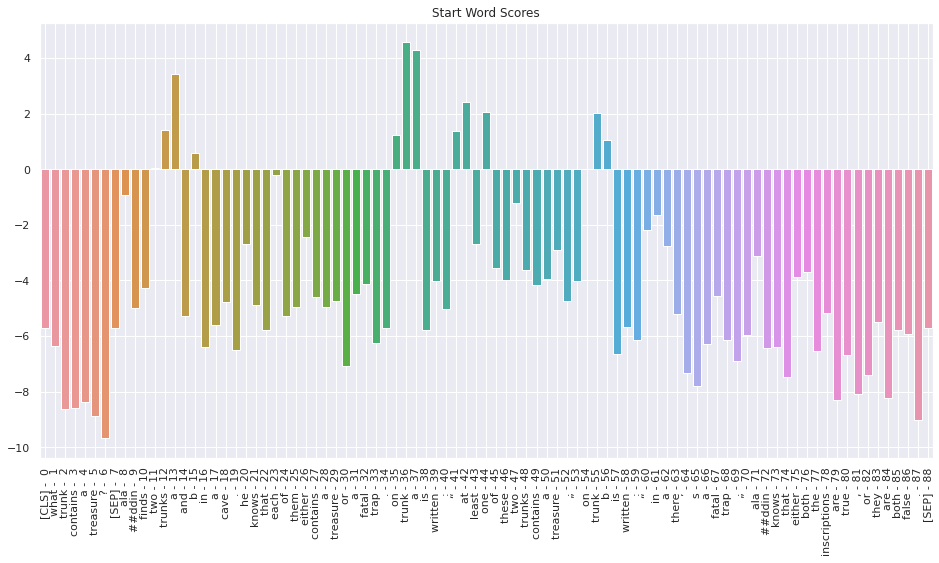

In [ ]:
question = "What trunk contains a treasure?"
context = """Aladdin finds two trunks A and B in a cave. 
            He knows that each of them either contains a treasure or a fatal trap.
            On trunk A is written: “ At least one of these two trunks contains a treasure.”
            On trunk B is written: “ In A there’s a fatal trap.”
            Aladdin knows that either both the inscriptions are true, or they are both false."""
# correct answer: B
output = nlp(question = question, context = context)
print(output)
visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)

Let's see the heatmap

In [ ]:
score_matrix = np.zeros((100,100))
for i in range(100):
  for j in range(100):
    question = "Who has more shares?"
    if i+j <=100:
      context = """Polly holds {}% of shares. Eugene holds {}% of shares.""".format(i, j)
      result = get_best_answer_score(question=question, answer_text=context, model=model, tokenizer=tokenizer)

      answers_map = {'polly': 'eugene', 'eugene': 'polly'}

      if i >= j:
        correct_answer = 'polly'
      else:
        correct_answer = 'eugene'
      if correct_answer in result["answer"]:
        score_matrix[i,j] = result["score"]
      elif answers_map[correct_answer] in result["answer"]:
        score_matrix[i,j] = - result["score"]
      else:
        score_matrix[i,j] = None
  print(score_matrix[i])


# visualize_bert_for_qa(question=question, answer_text=context, model=model, tokenizer=tokenizer)
# print(get_best_answer_score(question=question, answer_text=context, model=model, tokenizer=tokenizer))

[-9.94912529 12.88299942 12.92364502 13.4562912  12.94319916 12.65591431
 12.69367027 13.07276726 13.50121117 13.30031967 13.34716129 13.36777401
 13.42095184 13.20082092 12.84684753 12.76766586 12.8977375  12.87155151
 12.93113518 12.94205189 12.75874996 13.01022243 12.59944344 12.8913002
 12.59557819 12.6249752  12.80548477 13.08117294 13.01503181 13.0479393
 13.02103996 12.75319099 12.9172945  12.78114033 12.82603836 12.82976341
 12.5529995  12.80088043 12.53782749 12.43148041 12.62583733 12.59067535
 12.36312675 12.55250359 12.61550331 12.48106194 12.6684742  12.63581657
 12.30505848 12.45775032 12.45456886 12.3158741  12.13555908 12.30421257
 12.02912903 12.09038162 12.09975433 12.18132019 12.05310059 12.15852737
 12.40860176 12.48459816 12.41193199 12.09107399 12.37933064 12.45602036
 12.30387306 11.93315315 12.4590435  12.61841965 12.61249638 12.56961441
 12.19481277 12.54545975 12.25892067 12.35742092 12.52775478 12.21660042
 11.979599   12.33320236 12.48431492 12.74845314 12.3

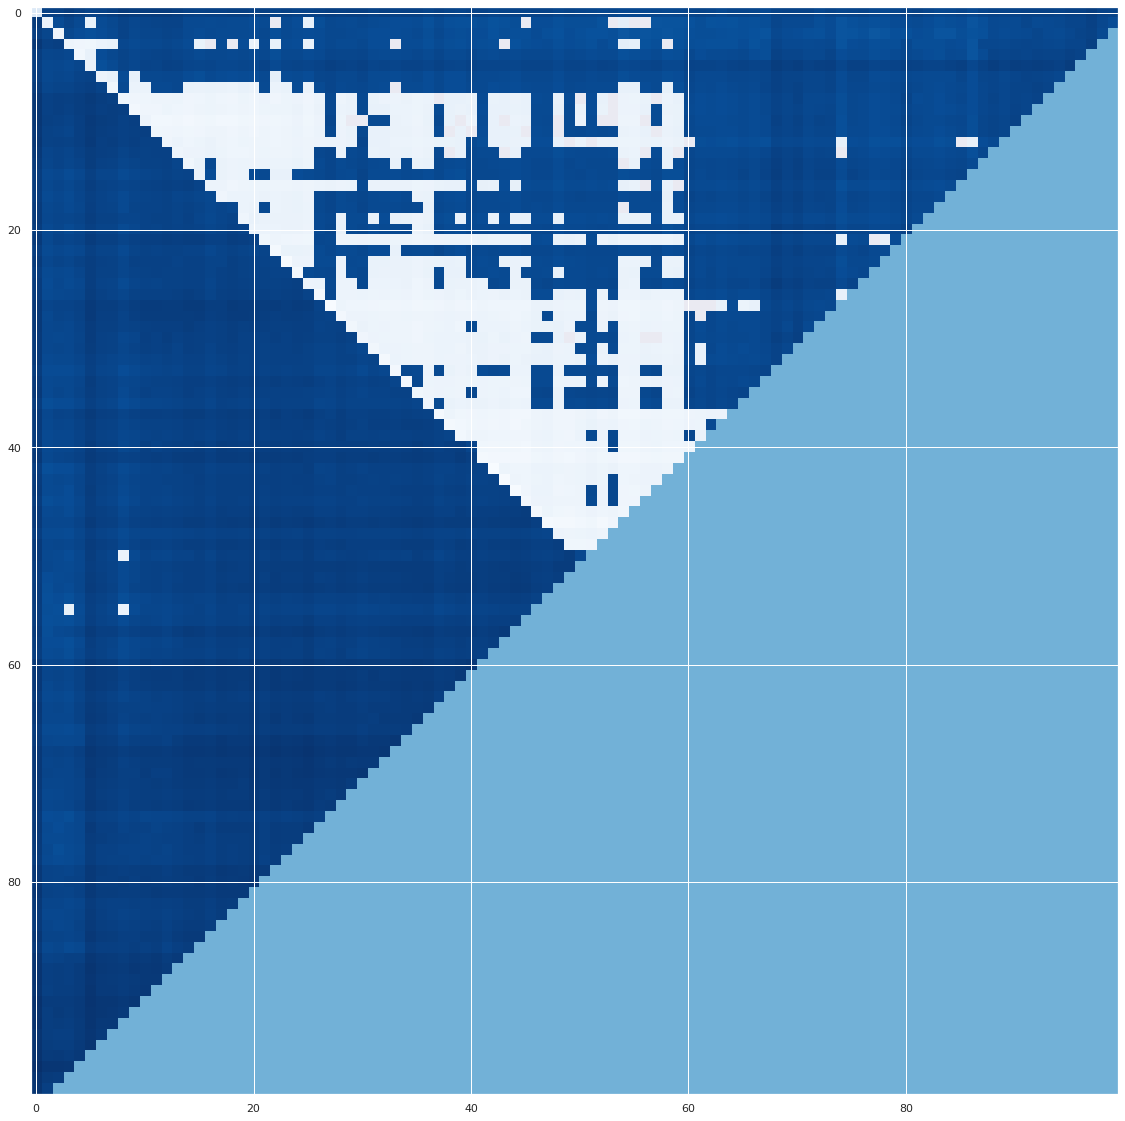

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20,20))
plt.imshow(score_matrix, cmap='Blues')
plt.show()

We can see that in the first half of experiments, when Polly had actually less stocks than Eugene, BERT still predicted that Polly has more stocks ~50% of the time.

When Polly actually had more stocks than Eugene - all was fine. This means that BERT is more likely to prodicts the first person. Also, we see that in first 5-7 numbers (when the distribution was Polly has 0-7, Eugene has 0-100). Than, when Eugene had > 60 - BERT had it right almost always.

In [ ]:
score_matrix = np.zeros((100,100))
for i in range(100):
  for j in range(100):
    question = "Who has less shares?"
    if i+j <=100:
      context = """Polly holds {}% of shares. Eugene holds {}% of shares.""".format(i, j)
      result = get_best_answer_score(question=question, answer_text=context, model=model, tokenizer=tokenizer)

      answers_map = {'polly': 'eugene', 'eugene': 'polly'}

      if i <= j:
        correct_answer = 'polly'
      else:
        correct_answer = 'eugene'
      if correct_answer in result["answer"]:
        score_matrix[i,j] = result["score"]
      elif answers_map[correct_answer] in result["answer"]:
        score_matrix[i,j] = - result["score"]
      else:
        score_matrix[i,j] = None
  print(score_matrix[i])


[-14.1813755   13.70757866  13.48780823  13.8355999   13.74032593
  13.7281456   13.80455589  14.14966488  14.11268044  14.00981331
  13.84334373  13.49538422  13.6387167   14.02875137  14.24880886
  14.09087849  14.13951206  14.3790226   13.89954853  13.7967968
  14.03496933  14.00798225  13.96796989  13.74198341  14.39488983
  14.22480965  14.49222374  14.56534481  14.25958157  13.96751404
  13.93586445  13.85516262  14.04872704  14.33100319  14.28115273
  14.10288239  14.02902603  14.02108383  14.11349678  14.31409836
  14.35743904  14.26078606  14.50456524  14.44540405  14.41075897
  14.12089729  13.96231651  14.22206879  14.30212212  14.33479118
  14.26203918  14.46614361  14.55131531  14.5678606   14.41460323
  14.41389561  14.46155262  14.52302933  14.35241318  14.45809174
  14.06675148  14.22637558  14.37904358  14.65056992  14.38667393
  14.74137688  14.67483521  15.06361771  14.91136169  14.80252361
  14.66217613  14.59593201  14.5735569   14.5969677   14.49520588
  14.434951

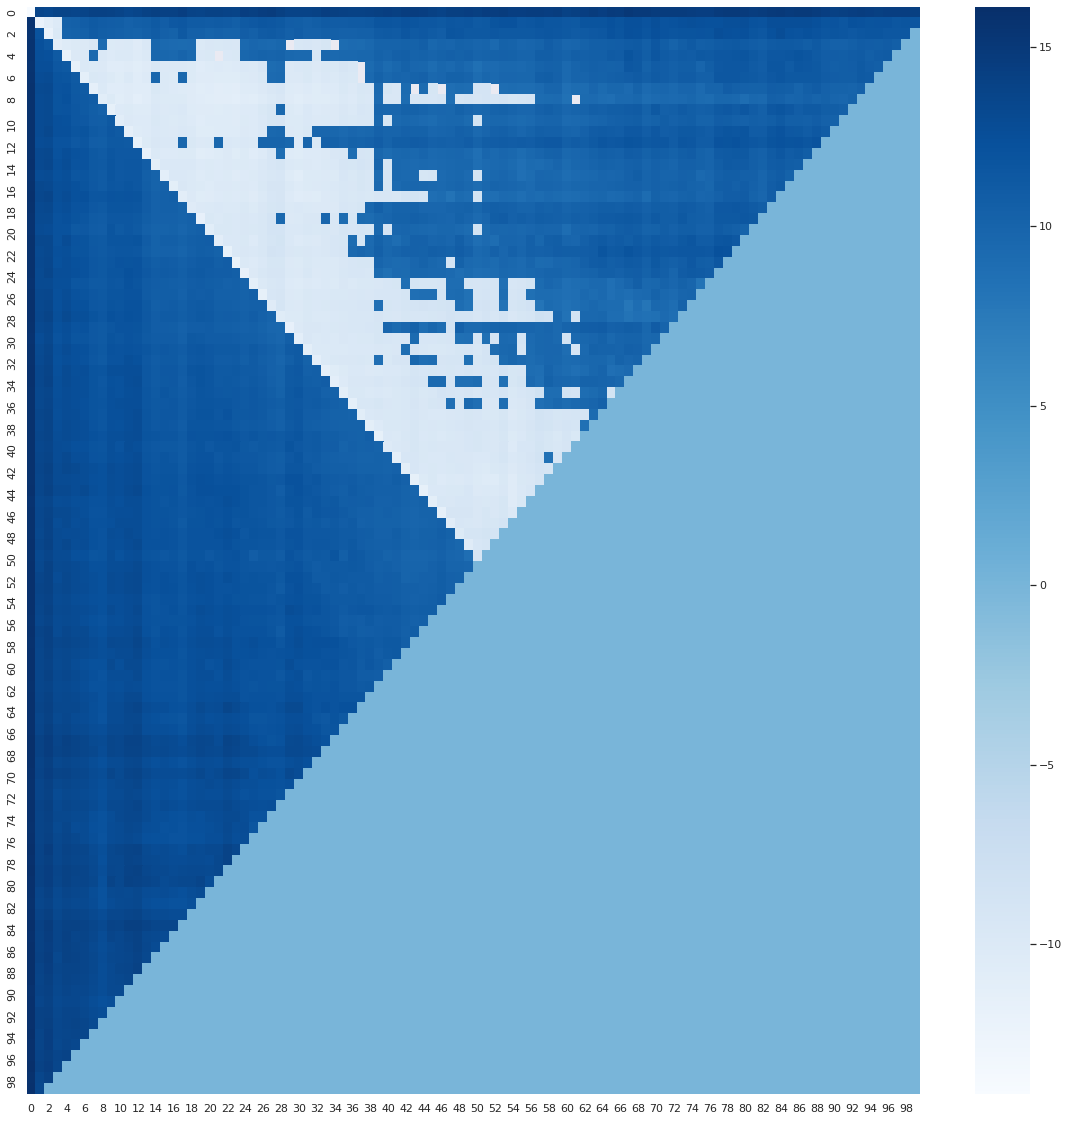

In [ ]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(score_matrix, cmap='Blues', cbar=True)

In [ ]:
score_matrix = np.zeros((100,100))
for i in range(100):
  for j in range(100):
    question = "Who has more shares?"
    if i+j <=100:
      context = """Polly holds {}% of shares. Eugene holds {}% of shares.""".format(j, i)
      result = get_best_answer_score(question=question, answer_text=context, model=model, tokenizer=tokenizer)

      answers_map = {'polly': 'eugene', 'eugene': 'polly'}

      if i <= j:
        correct_answer = 'polly'
      else:
        correct_answer = 'eugene'
      if correct_answer in result["answer"]:
        score_matrix[i,j] = result["score"]
      elif answers_map[correct_answer] in result["answer"]:
        score_matrix[i,j] = - result["score"]
      else:
        score_matrix[i,j] = None
  print(score_matrix[i])


[-9.94912529 13.52640724 13.08121681 13.81524277 13.18806839 13.02148056
 13.12848663 13.51245308 13.9377327  13.94781113 14.01179314 13.83154678
 13.91911697 13.74322319 13.54443359 13.28226948 13.41579819 13.283288
 13.47963333 13.50102997 13.30550957 13.602911   13.23183441 13.52569199
 13.22765732 13.45185852 13.38712883 13.80108261 13.78938675 13.70387173
 13.6493721  13.59747696 13.60700607 13.34986115 13.64128876 13.72014236
 13.28490829 13.67561913 13.58469105 13.40018368 13.54272461 13.77149391
 13.2042942  13.4463377  13.50135231 13.32193184 13.58282852 13.67597008
 13.21226692 13.6157608  13.58729362 13.44136429 13.28185749 13.46306992
 13.39736938 13.24707031 13.2655201  13.51077461 13.27191257 13.22444725
 13.75483227 13.85830879 13.83322811 13.46901894 13.86047554 13.76708984
 13.41444206 13.48747349 13.88716888 13.90828419 13.90671253 13.76583481
 13.62684631 13.80806732 13.58970451 13.76532173 13.67342854 13.57241154
 13.36355782 13.87895393 13.80130005 14.13335991 13.7

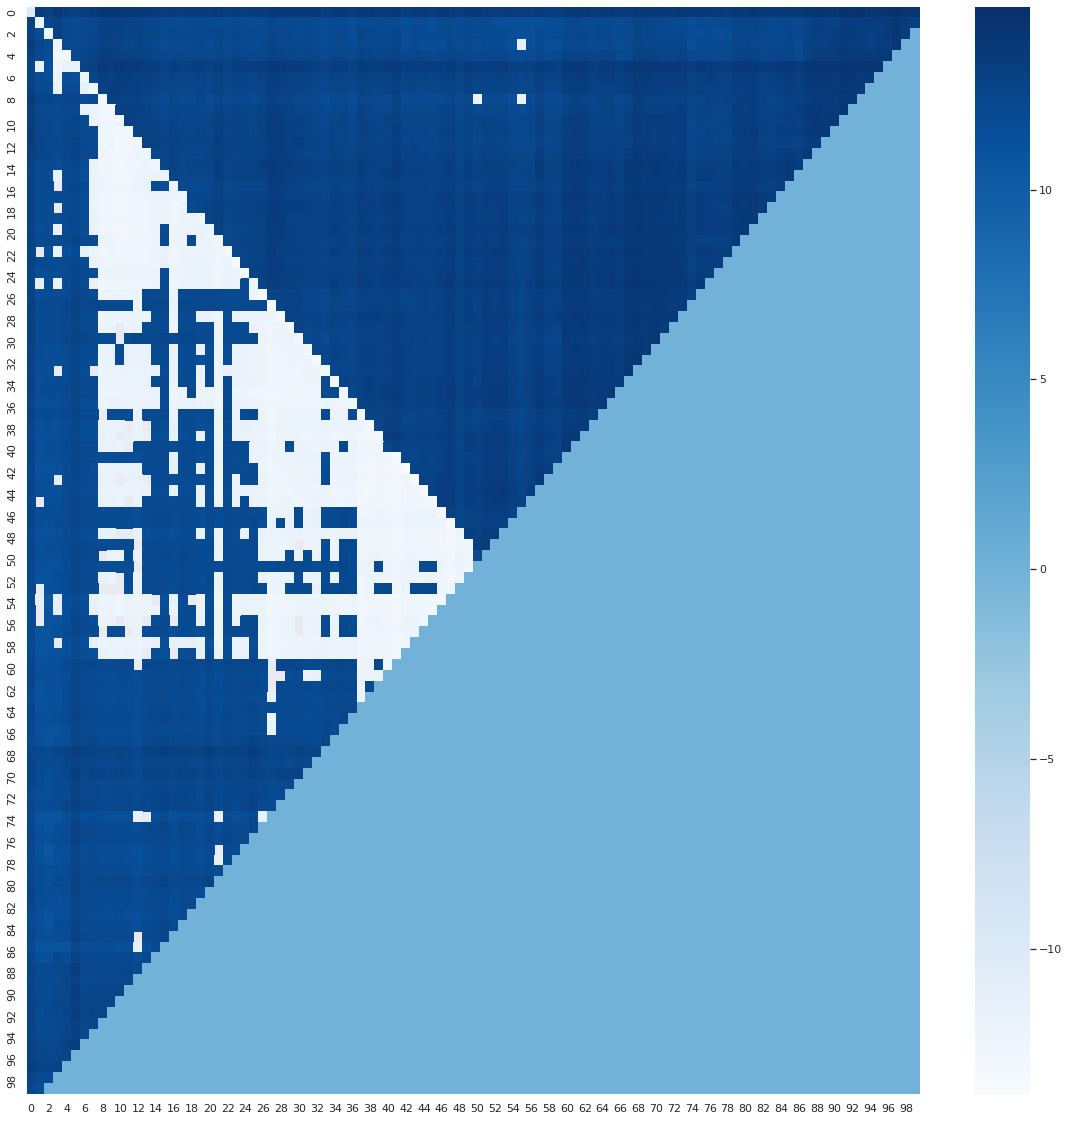

In [ ]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(score_matrix, cmap='Blues', cbar=True)

In [ ]:
score_matrix = np.zeros((100,100))
for i in range(100):
  for j in range(100):
    question = "Who has more shares?"
    if i+j <=100:
      context = """Eugene holds {}% of shares. Polly holds {}% of shares.""".format(j, i)
      result = get_best_answer_score(question=question, answer_text=context, model=model, tokenizer=tokenizer)

      answers_map = {'polly': 'eugene', 'eugene': 'polly'}

      if i >= j:
        correct_answer = 'polly'
      else:
        correct_answer = 'eugene'
      if correct_answer in result["answer"]:
        score_matrix[i,j] = result["score"]
      elif answers_map[correct_answer] in result["answer"]:
        score_matrix[i,j] = - result["score"]
      else:
        score_matrix[i,j] = None
  print(score_matrix[i])

[10.83258724 13.0731678  12.69562244 13.3224268  12.78661537 12.66680145
 12.71673012 13.12149048 13.41292953 13.52188492 13.60009193 13.38458633
 13.44557285 13.26243305 13.02286434 12.79720211 12.93600655 12.78646088
 13.0158062  13.02229118 12.86116028 13.09326744 12.84160709 13.04385757
 12.70350456 12.97512245 12.83236599 13.25493717 13.21846008 13.16580009
 13.11859894 13.10935593 13.06531143 12.85993671 13.07944107 13.19247246
 12.75406361 13.12964439 12.95793915 12.76686287 13.02021694 13.14226913
 12.60804367 12.99474144 12.96635056 12.80834961 13.04298019 13.17909813
 12.80181122 13.11086464 13.12635612 12.96949196 12.79826641 12.95046043
 12.86835289 12.77504349 12.7737627  12.88921165 12.74543667 12.671628
 13.247612   13.27257919 13.26669788 12.88627148 13.25920868 13.21814537
 12.83483315 12.8457489  13.35313797 13.3827877  13.37402534 13.17867279
 13.02513885 13.28173065 13.034338   13.15643501 13.15919304 13.0337534
 12.80810928 13.31926346 13.23113441 13.53887367 13.14

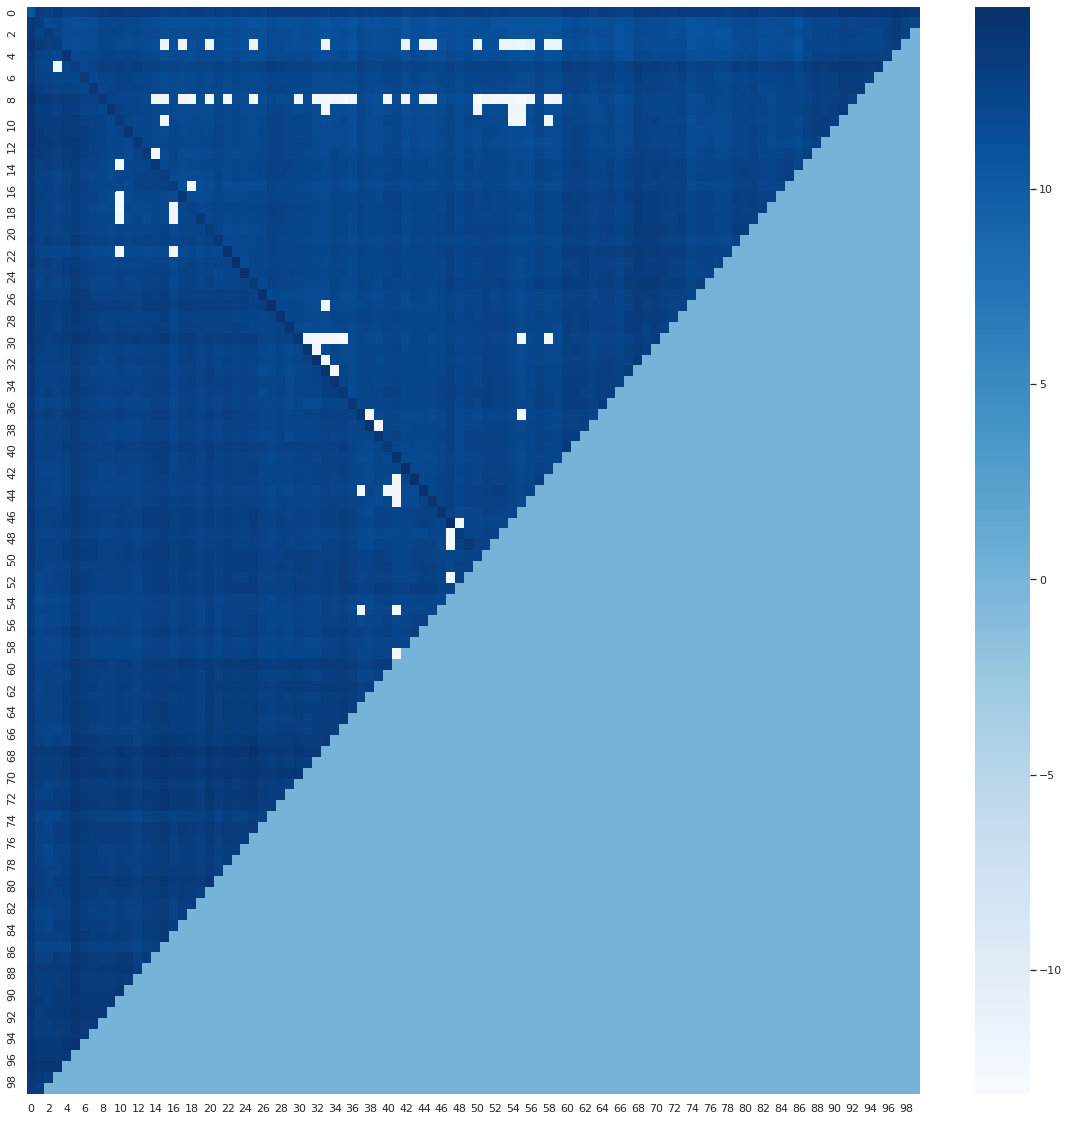

In [ ]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(score_matrix, cmap='Blues', cbar=True)

In [ ]:
score_matrix = np.zeros((100,100))
for i in range(100):
  for j in range(100):
    question = "Who has more shares?"
    if i+j <=100:
      context = """John holds {}% of shares. Maria holds {}% of shares.""".format(j, i)
      result = get_best_answer_score(question=question, answer_text=context, model=model, tokenizer=tokenizer)

      answers_map = {'maria': 'john', 'john': 'maria'}

      if i >= j:
        correct_answer = 'maria'
      else:
        correct_answer = 'john'
      if correct_answer in result["answer"]:
        score_matrix[i,j] = result["score"]
      elif answers_map[correct_answer] in result["answer"]:
        score_matrix[i,j] = - result["score"]
      else:
        score_matrix[i,j] = None
  print(score_matrix[i])

[10.33127785 12.70835114 12.35319138 12.97870064 12.36839676 12.22245026
 12.30700302 12.64428711 12.97835541 13.10678768 13.14128876 12.93378258
 12.98179626 12.85536194 12.54842949 12.31408119 12.47353745 12.31114578
 12.55160332 12.61092186 12.44875336 12.66569614 12.42368126 12.6844883
 12.17591572 12.49185944 12.36633205 12.78425407 12.72039795 12.62253761
 12.70619392 12.56982422 12.60102463 12.42195415 12.62898827 12.77752686
 12.24033928 12.69187737 12.52571487 12.29620934 12.68491554 12.73715687
 12.20265388 12.49220562 12.46343994 12.36303329 12.57629204 12.7609129
 12.30405617 12.66893196 12.62146759 12.54838562 12.41085052 12.46061516
 12.43159676 12.33828926 12.30697536 12.4214325  12.30822277 12.23188591
 12.8129015  12.80432892 12.80795479 12.34918022 12.88924599 12.86837196
 12.44866371 12.56381416 12.98525429 13.02999878 13.00815868 12.7821312
 12.66073036 12.86964417 12.52951336 12.76839638 12.7471323  12.64660072
 12.40522385 12.97153473 12.86560631 13.11969948 12.71

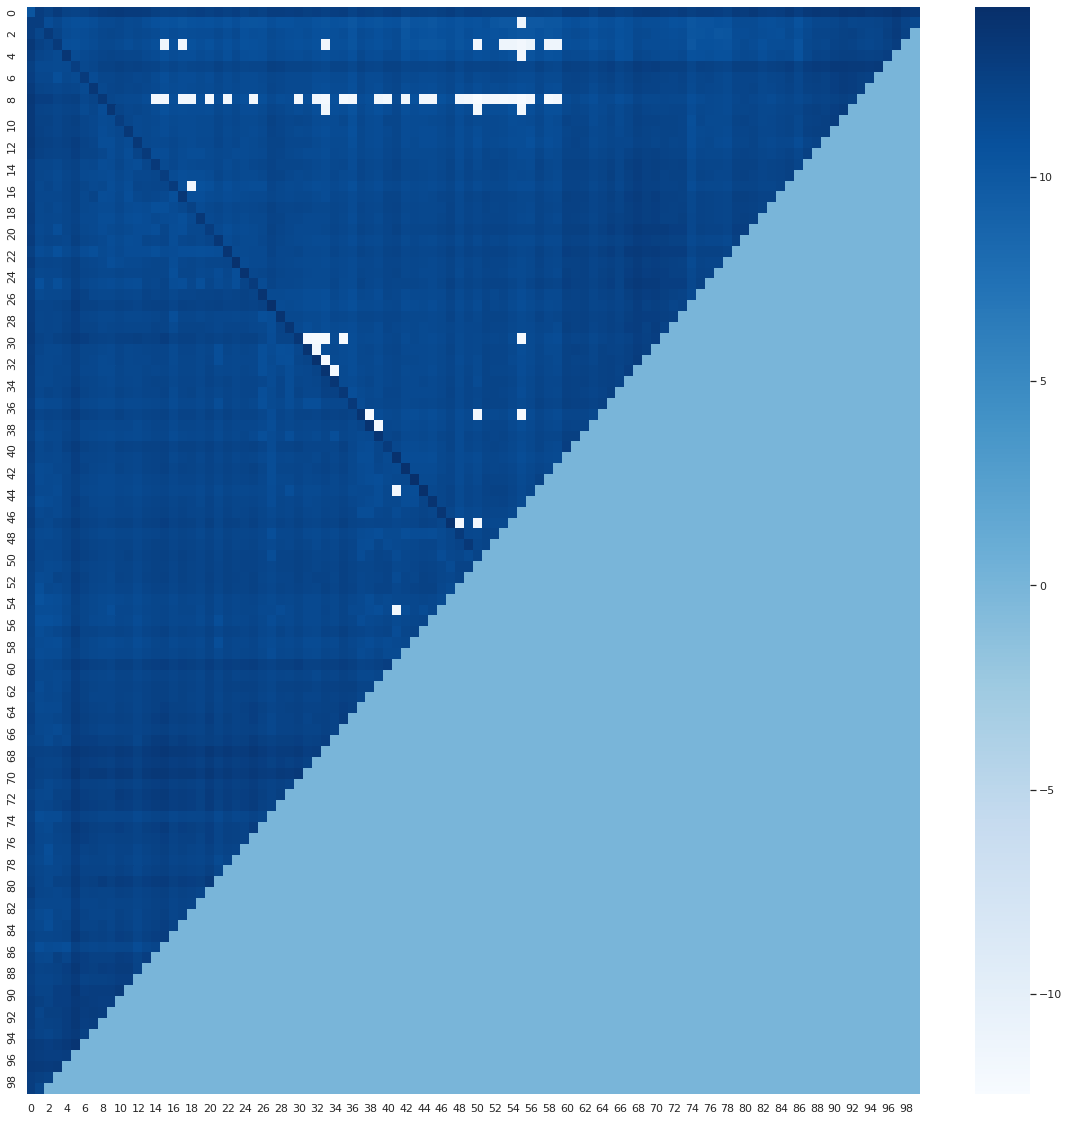

In [ ]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(score_matrix, cmap='Blues', cbar=True)

In [ ]:
score_matrix = np.zeros((100,100))
for i in range(100):
  for j in range(100):
    question = "Who has more shares?"
    if i+j <=100:
      context = """Maria holds {}% of shares. John holds {}% of shares.""".format(j, i)
      result = get_best_answer_score(question=question, answer_text=context, model=model, tokenizer=tokenizer)

      answers_map = {'maria': 'john', 'john': 'maria'}

      if i <= j:
        correct_answer = 'maria'
      else:
        correct_answer = 'john'
      if correct_answer in result["answer"]:
        score_matrix[i,j] = result["score"]
      elif answers_map[correct_answer] in result["answer"]:
        score_matrix[i,j] = - result["score"]
      else:
        score_matrix[i,j] = None
  print(score_matrix[i])

[-10.59104156  13.0708313   12.56252003  13.17819309  12.6112709
  12.46084595  12.50335503  12.73726273  13.09238243  13.29506111
  13.20630455  13.0927763   13.14492989  12.94981766  12.5917778
  12.48583221  12.59931374  12.37242985  12.67290688  12.80000114
  12.51521683  12.68668938  12.49775314  12.81673813  12.2900219
  12.63893127  12.4894619   12.86355591  12.79118347  12.9010582
  12.89296246  12.8824749   12.80951309  12.64628983  12.74772835
  12.85630417  12.38516426  12.83195877  12.72071552  12.43298912
  12.59833527  12.85130882  12.18194771  12.44496346  12.45310974
  12.29000759  12.60335159  12.82298374  12.30167961  12.65799332
  12.73000145  12.48796082  12.31379318  12.39448357  12.45089531
  12.23571873  12.29666424  12.3743763   12.26016617  12.29417133
  12.84076309  12.92183304  12.96396446  12.30129433  12.89472389
  12.93054962  12.47762108  12.42209816  12.80877781  12.97043228
  12.8950882   12.73544788  12.52940178  12.76700974  12.55877113
  12.74700737 

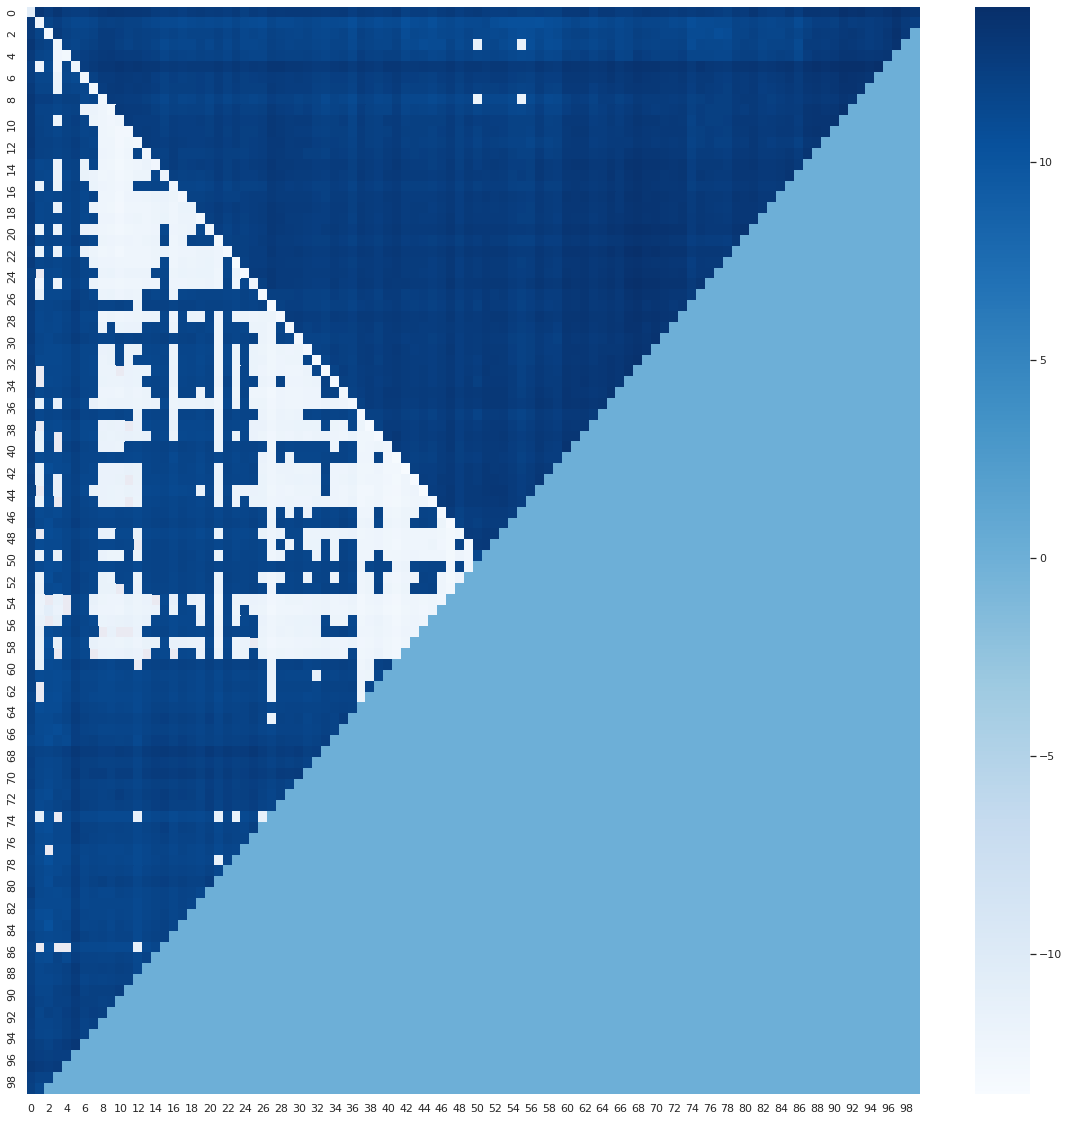

In [ ]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(score_matrix, cmap='Blues', cbar=True)

In [ ]:
score_matrix = np.zeros((50,50))
for i in range(50):
  for j in range(50):
    question = "Who has more dollars?"
    context = """Eugene has {} dollars. Polly has {} dollars.""".format(j+181734672, i+181734672)
    result = get_best_answer_score(question=question, answer_text=context, model=model, tokenizer=tokenizer)

    answers_map = {'polly': 'eugene', 'eugene': 'polly'}

    if i >= j:
      correct_answer = 'polly'
    else:
      correct_answer = 'eugene'
    if correct_answer in result["answer"]:
      score_matrix[i,j] = result["score"]
    elif answers_map[correct_answer] in result["answer"]:
      score_matrix[i,j] = - result["score"]
    else:
      score_matrix[i,j] = None
  print(score_matrix[i])

[ 14.77994728 -13.22017765 -13.15790176 -12.68411541 -13.05298233
 -13.10029221 -13.23610401 -13.19437408 -12.34258556 -12.93885231
 -13.80138016 -13.00992203 -12.55040932 -12.65497875 -12.34311104
 -13.27218819 -12.8281498  -12.69652748 -12.23075581 -12.67646027
 -13.41824722 -12.71515369 -12.32847691 -12.47337246 -12.26618004
 -13.29282761 -12.62826157 -12.44432354 -12.22959805 -12.40086365
 -12.72594261 -12.21517563 -12.13449669 -12.31316185 -12.63414001
 -12.4255476  -12.37862015 -12.28859711 -12.38922024 -12.50012398
 -12.45051384 -12.33041382 -12.07203007 -12.02171612 -12.27871323
 -12.26296425 -12.37363625 -12.1308651  -12.34311295 -12.43408394]
[ 13.57990456  14.73419571 -13.48359585 -12.69200516 -13.24295902
 -13.32040215 -13.47339821 -13.4205246  -12.40748978 -12.94637966
 -12.83739662 -13.83192253 -12.5896225  -12.69964027 -12.44427872
 -13.51794815 -12.81581593 -12.70541954 -12.30941391 -12.67469788
 -12.5991888  -13.40557289 -12.37463379 -12.47334576 -12.22764874
 -13.5479

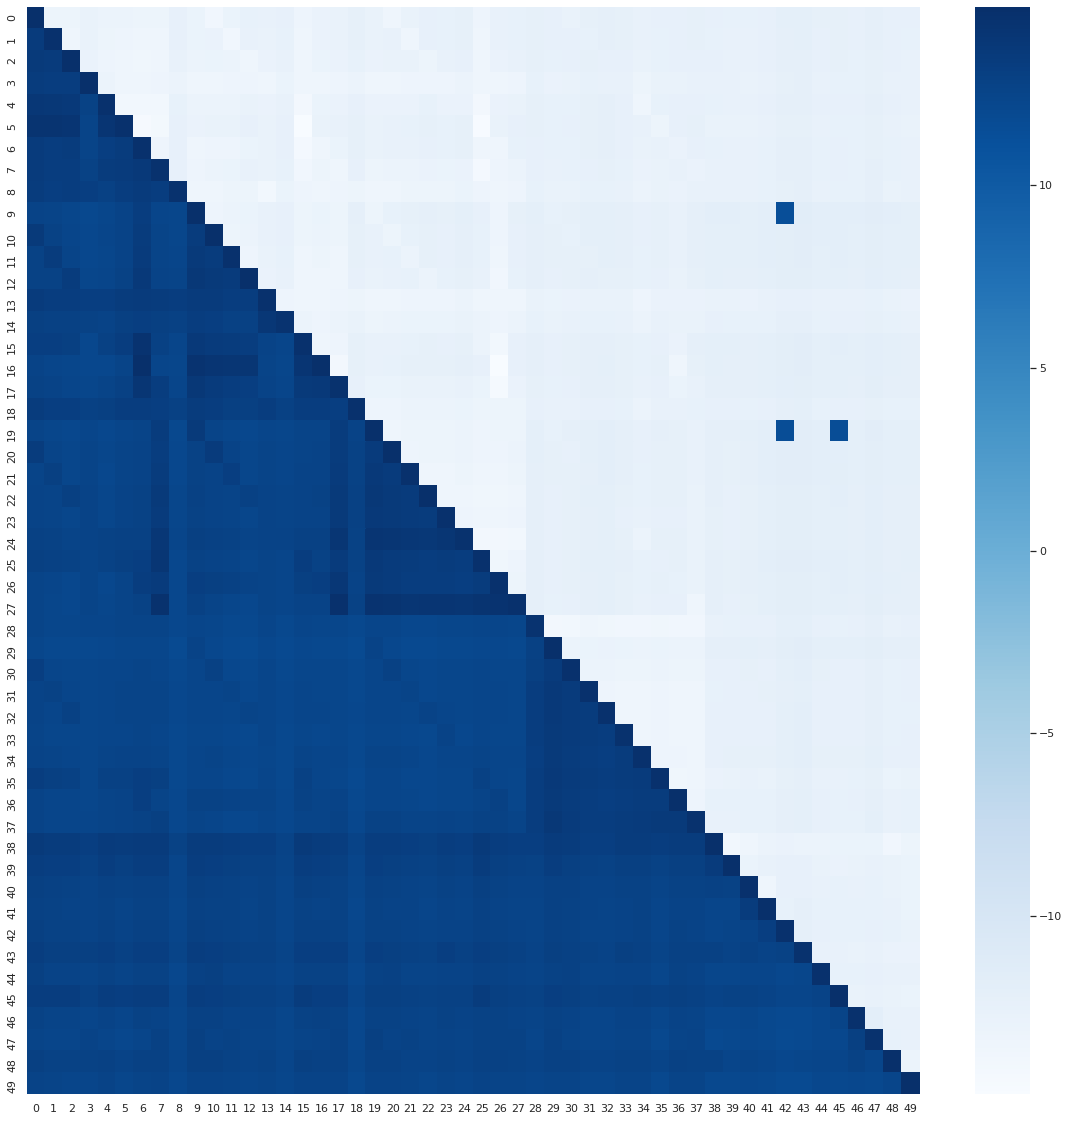

In [ ]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(score_matrix, cmap='Blues', cbar=True)

In [ ]:
score_matrix = np.zeros((50,50))
for i in range(50):
  for j in range(50):
    question = "Who has more dollars?"
    context = """Polly has {} dollars. Eugene has {} dollars.""".format(j+181734672, i+181734672)
    result = get_best_answer_score(question=question, answer_text=context, model=model, tokenizer=tokenizer)

    answers_map = {'polly': 'eugene', 'eugene': 'polly'}

    if i <= j:
      correct_answer = 'polly'
    else:
      correct_answer = 'eugene'
    if correct_answer in result["answer"]:
      score_matrix[i,j] = result["score"]
    elif answers_map[correct_answer] in result["answer"]:
      score_matrix[i,j] = - result["score"]
    else:
      score_matrix[i,j] = None
  print(score_matrix[i])

[-14.9232378  -12.90488815 -12.83635139 -12.14396286 -12.78028202
 -12.85305977 -12.95104027 -12.88784599 -11.73593998 -12.41680527
 -13.64267063 -12.48807526 -11.94538784 -12.02856731 -11.69940567
 -12.95842648 -12.26839638 -12.12272263 -11.64307594 -12.11253166
 -13.10720444 -12.14216995 -11.705019   -11.80508709 -11.6282568
 -12.94983482 -12.04757118 -11.82044029  11.45683479 -11.71260643
 -11.95331383  11.5150528   11.64444733 -11.52954102 -11.95225143
 -11.71701527 -11.63425064  11.45654392 -11.69617367 -11.88734627
 -11.70214844 -11.63134956  11.66434574  11.60473633 -11.63101196
  11.64339256 -11.72505569 -11.49393654 -11.59420013 -11.64600945]
[ 13.29953384 -14.89586353 -13.23156166 -12.13298607 -13.02230453
 -13.13193512 -13.24290657 -13.16361904 -11.79978561 -12.41838074
 -12.22658539 -13.69475746 -11.97420311 -12.07672977 -11.81700611
 -13.24618912 -12.2429142  -12.11968994 -11.7122097  -12.11014557
 -11.95026493 -13.10046864 -11.74713135 -11.79619026 -11.58704567
 -13.24107

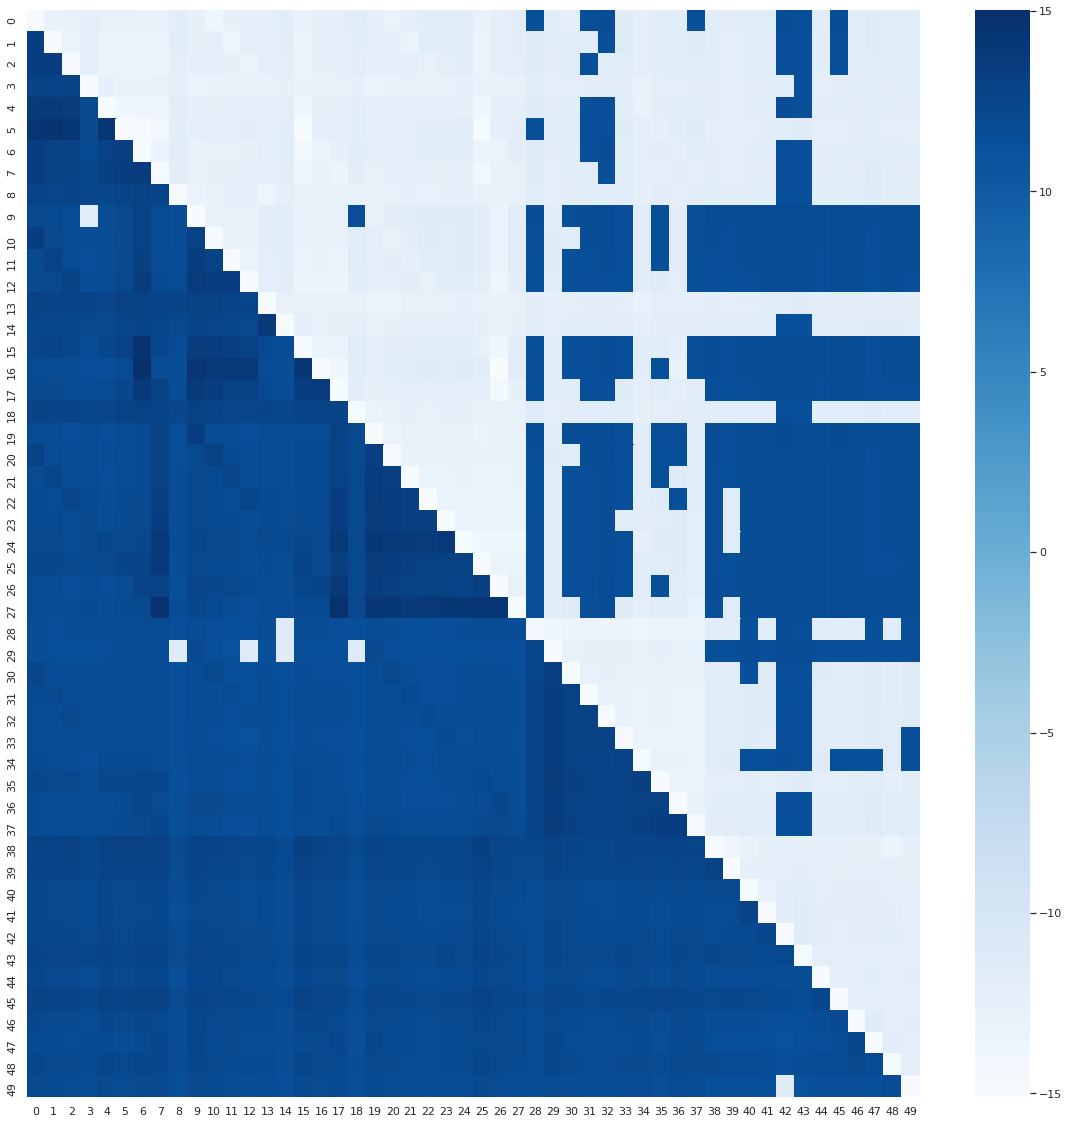

In [ ]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(score_matrix, cmap='Blues', cbar=True)

In [ ]:
score_matrix = np.zeros((100,100))
for i in range(100):
  for j in range(100):
    question = "Who has more shares?"
    if i+j <=100:
      context = """Michael holds {}% of shares. John holds {}% of shares.""".format(j, i)
      result = get_best_answer_score(question=question, answer_text=context, model=model, tokenizer=tokenizer)

      answers_map = {'michael': 'john', 'john': 'michael'}

      if i <= j:
        correct_answer = 'michael'
      else:
        correct_answer = 'john'
      if correct_answer in result["answer"]:
        score_matrix[i,j] = result["score"]
      elif answers_map[correct_answer] in result["answer"]:
        score_matrix[i,j] = - result["score"]
      else:
        score_matrix[i,j] = None
  print(score_matrix[i])

[-10.43247223  12.42807961  12.12867641  12.81370354  12.15760994
  12.07040405  12.10156441  12.4393549   12.85104179  12.97794724
  12.90296841  12.80554581  12.79844284  12.72509956  12.3323822
  12.19274521  12.29880524  12.15499401  12.36615753  12.49878216
  12.23460293  12.44624329  12.24012375  12.50264168  11.93313026
  12.29700661  12.2267828   12.63342476  12.58171749  12.63672352
  12.55351639  12.53225517  12.52494144  12.41921043  12.51700115
  12.59683037  12.13209629  12.61370277  12.44881821  12.17489433
  12.27794838  12.54288578  11.93115997  12.27296638  12.26002502
  12.0657959   12.41573906  12.60477066  12.06808662  12.3877182
  12.29018879  12.29765797  12.06535721  12.20078087  12.28341103
  12.0892086   12.13286591  12.15715981  12.09717083  12.08669758
  12.51132298  12.69999027  12.64665413  12.03566742  12.64899063
  12.55283165  12.13896942  12.00430107  12.48036098  12.68050575
  12.52833557  12.57632446  12.2271595   12.52601242  12.23745728
  12.4456434

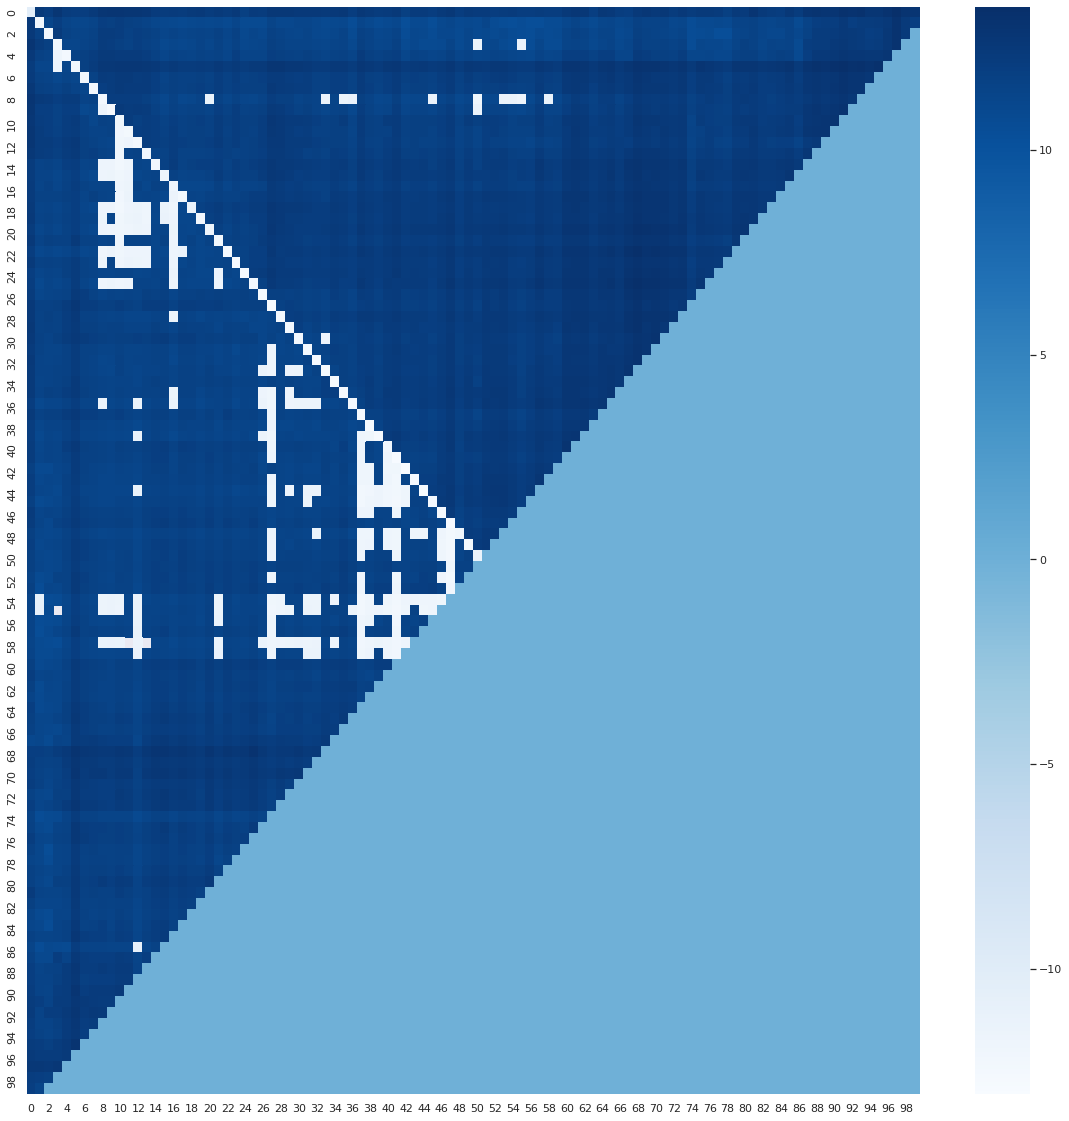

In [ ]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(score_matrix, cmap='Blues', cbar=True)

In [112]:
bert_partwise_similarity(list(itertools.combinations(['john', 'michael', 'eugene', 'polly', 'maria'], 2)), pretrained_bert_large, tokenizer_bert_large)

('john', 'michael') 0.9231773018836975
('john', 'eugene') 0.9105397462844849
('john', 'polly') 0.8618183732032776
('john', 'maria') 0.8658825159072876
('michael', 'eugene') 0.9028209447860718
('michael', 'polly') 0.8445681929588318
('michael', 'maria') 0.8598043322563171
('eugene', 'polly') 0.9075698852539062
('eugene', 'maria') 0.8884312510490417
('polly', 'maria') 0.8607785701751709
